# Code 7: Bayesian Additive Regression Trees

```{admonition} This is a reference notebook for the book Bayesian Modeling and Computation in Python
:class: tip, dropdown
The textbook is not needed to use or run this code, though the context and explanation is missing from this notebook.

If you'd like a copy it's available
[from the CRC Press](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368)
or from [Amazon](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).
``

In [28]:
%matplotlib inline
import arviz as az
import pymc as pm
import pymc_bart as pmb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler


In [29]:
az.style.use('arviz-grayscale')
plt.rcParams["figure.dpi"] = 300
np.random.seed(5453)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

## BART Bikes

In [30]:
data = pd.read_csv("../data/bikes_hour.csv")
data = data[::50]
data.sort_values(by='hour', inplace=True)
data.hour.values.astype(float)

X = np.atleast_2d(data["hour"]).T
Y = data["count"]

### Code 7.1

In [31]:
with pm.Model() as bart_g:
    σ = pm.HalfNormal('σ', Y.std())
    μ = pmb.BART('μ', X, Y, m=50)
    y = pm.Normal('y', μ, σ, observed=Y)
    idata_bart_g = pm.sample(2000, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 36 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


### Figure 7.4

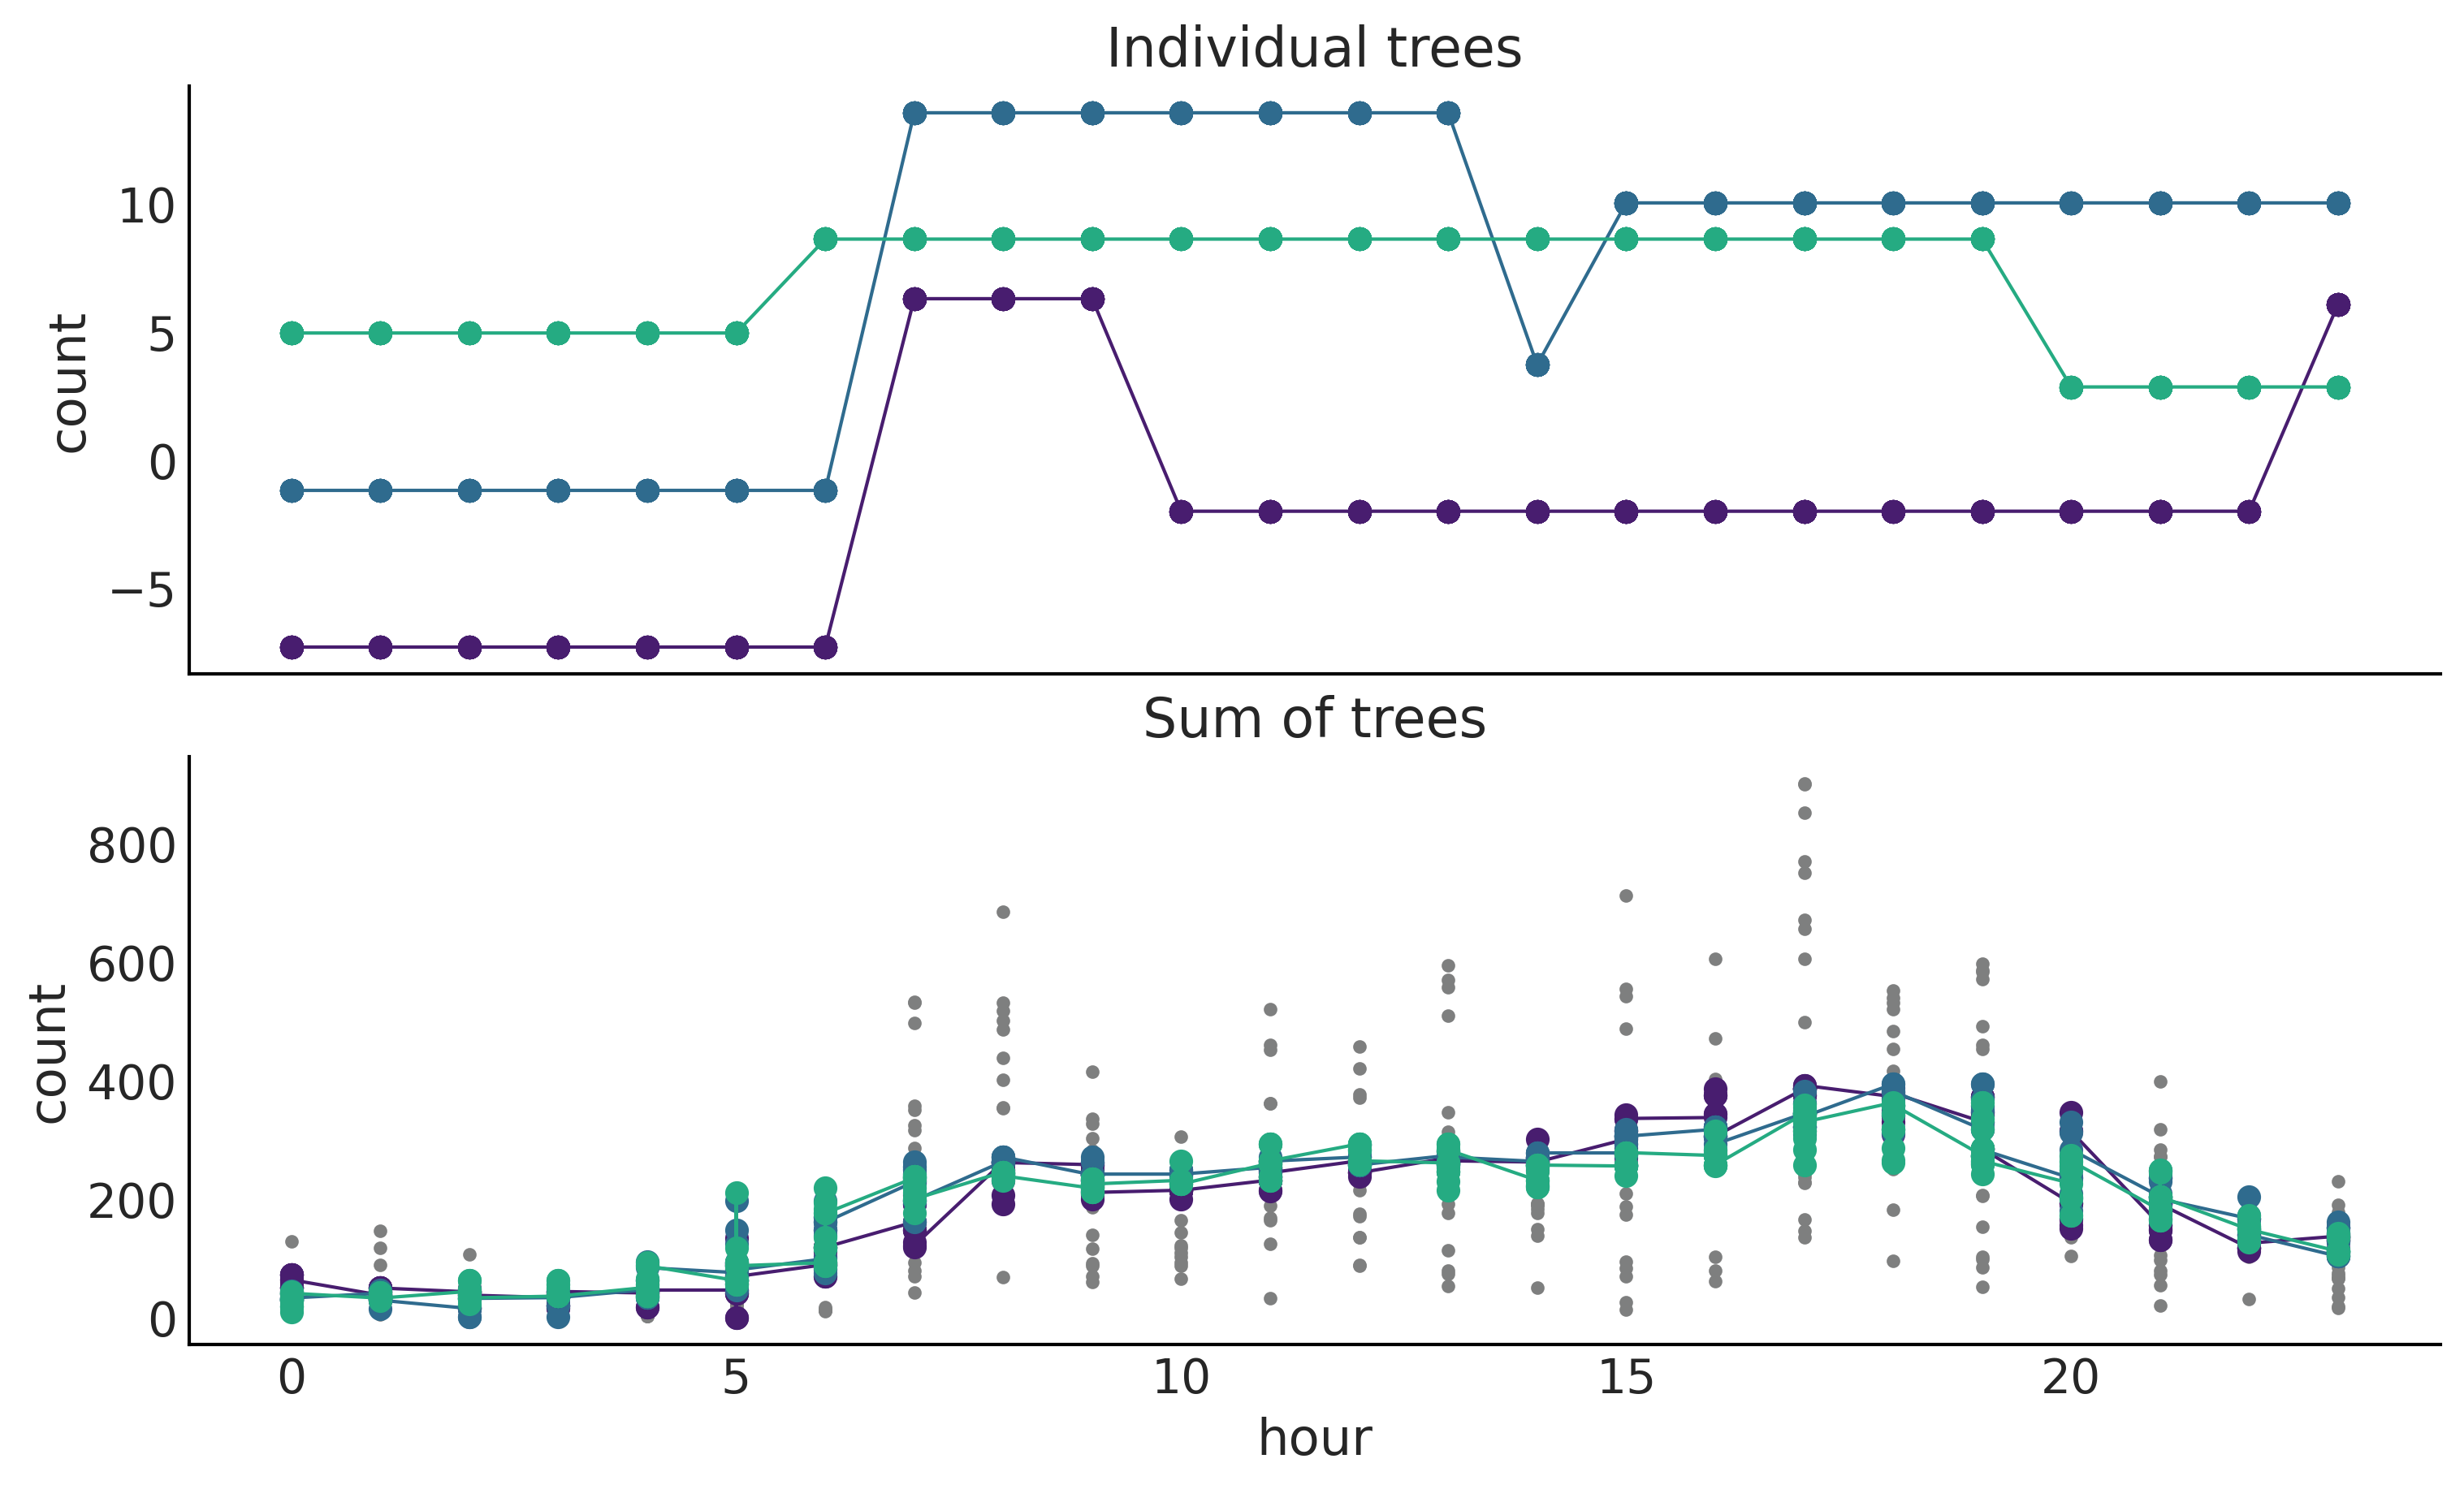

In [32]:
_, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].set_prop_cycle(cycler('color', viridish))
ax[1].set_prop_cycle(cycler('color', viridish))
for i in range(3):
    ax[0].plot(X, μ.owner.op.all_trees[i*10][0][i*2].predict(X)[0], "o-", lw=1)

posterior = idata_bart_g.posterior.stack(samples=("chain", "draw"))
for i in range(3):
    ax[1].plot(X, posterior["μ"].sel(draw=i*50), "o-", lw=1)
ax[1].plot(X, Y, "C2.", zorder=-1)

    
ax[0].set_ylabel("count")
ax[0].set_title("Individual trees")
ax[1].set_title("Sum of trees")
ax[1].set_xlabel("hour")
ax[1].set_ylabel("count")
plt.savefig('img/chp07/BART_bikes_samples.png')

### Code 7.5

/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


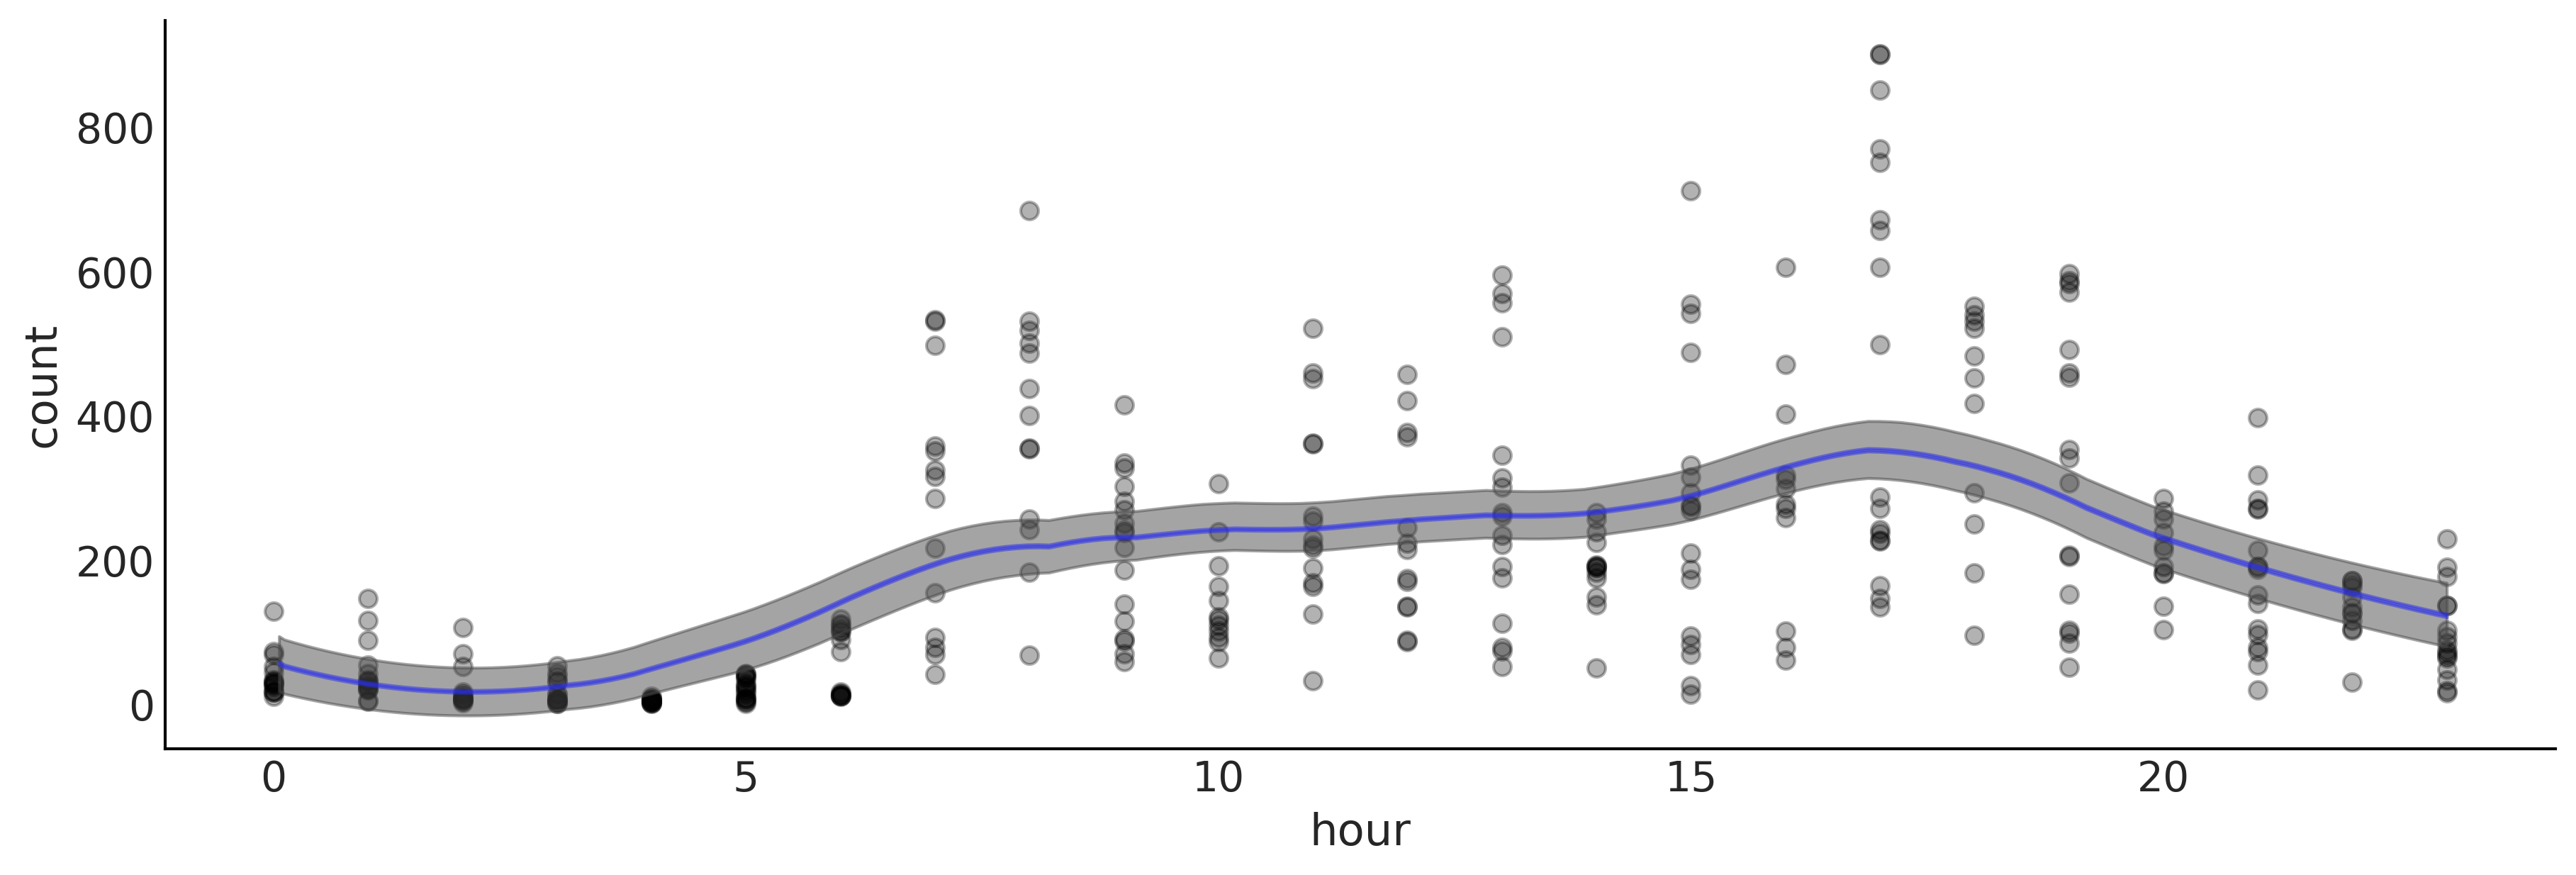

In [33]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(X, Y, "o", alpha=0.3, zorder=-1)
az.plot_hdi(X[:,0], posterior["μ"].T, smooth=True)
az.plot_hdi(X[:,0], posterior["μ"].T, hdi_prob=0.1, color="C4", smooth=True)

ax.set_xlabel("hour")
ax.set_ylabel("count")
plt.savefig('img/chp07/BART_bikes.png')

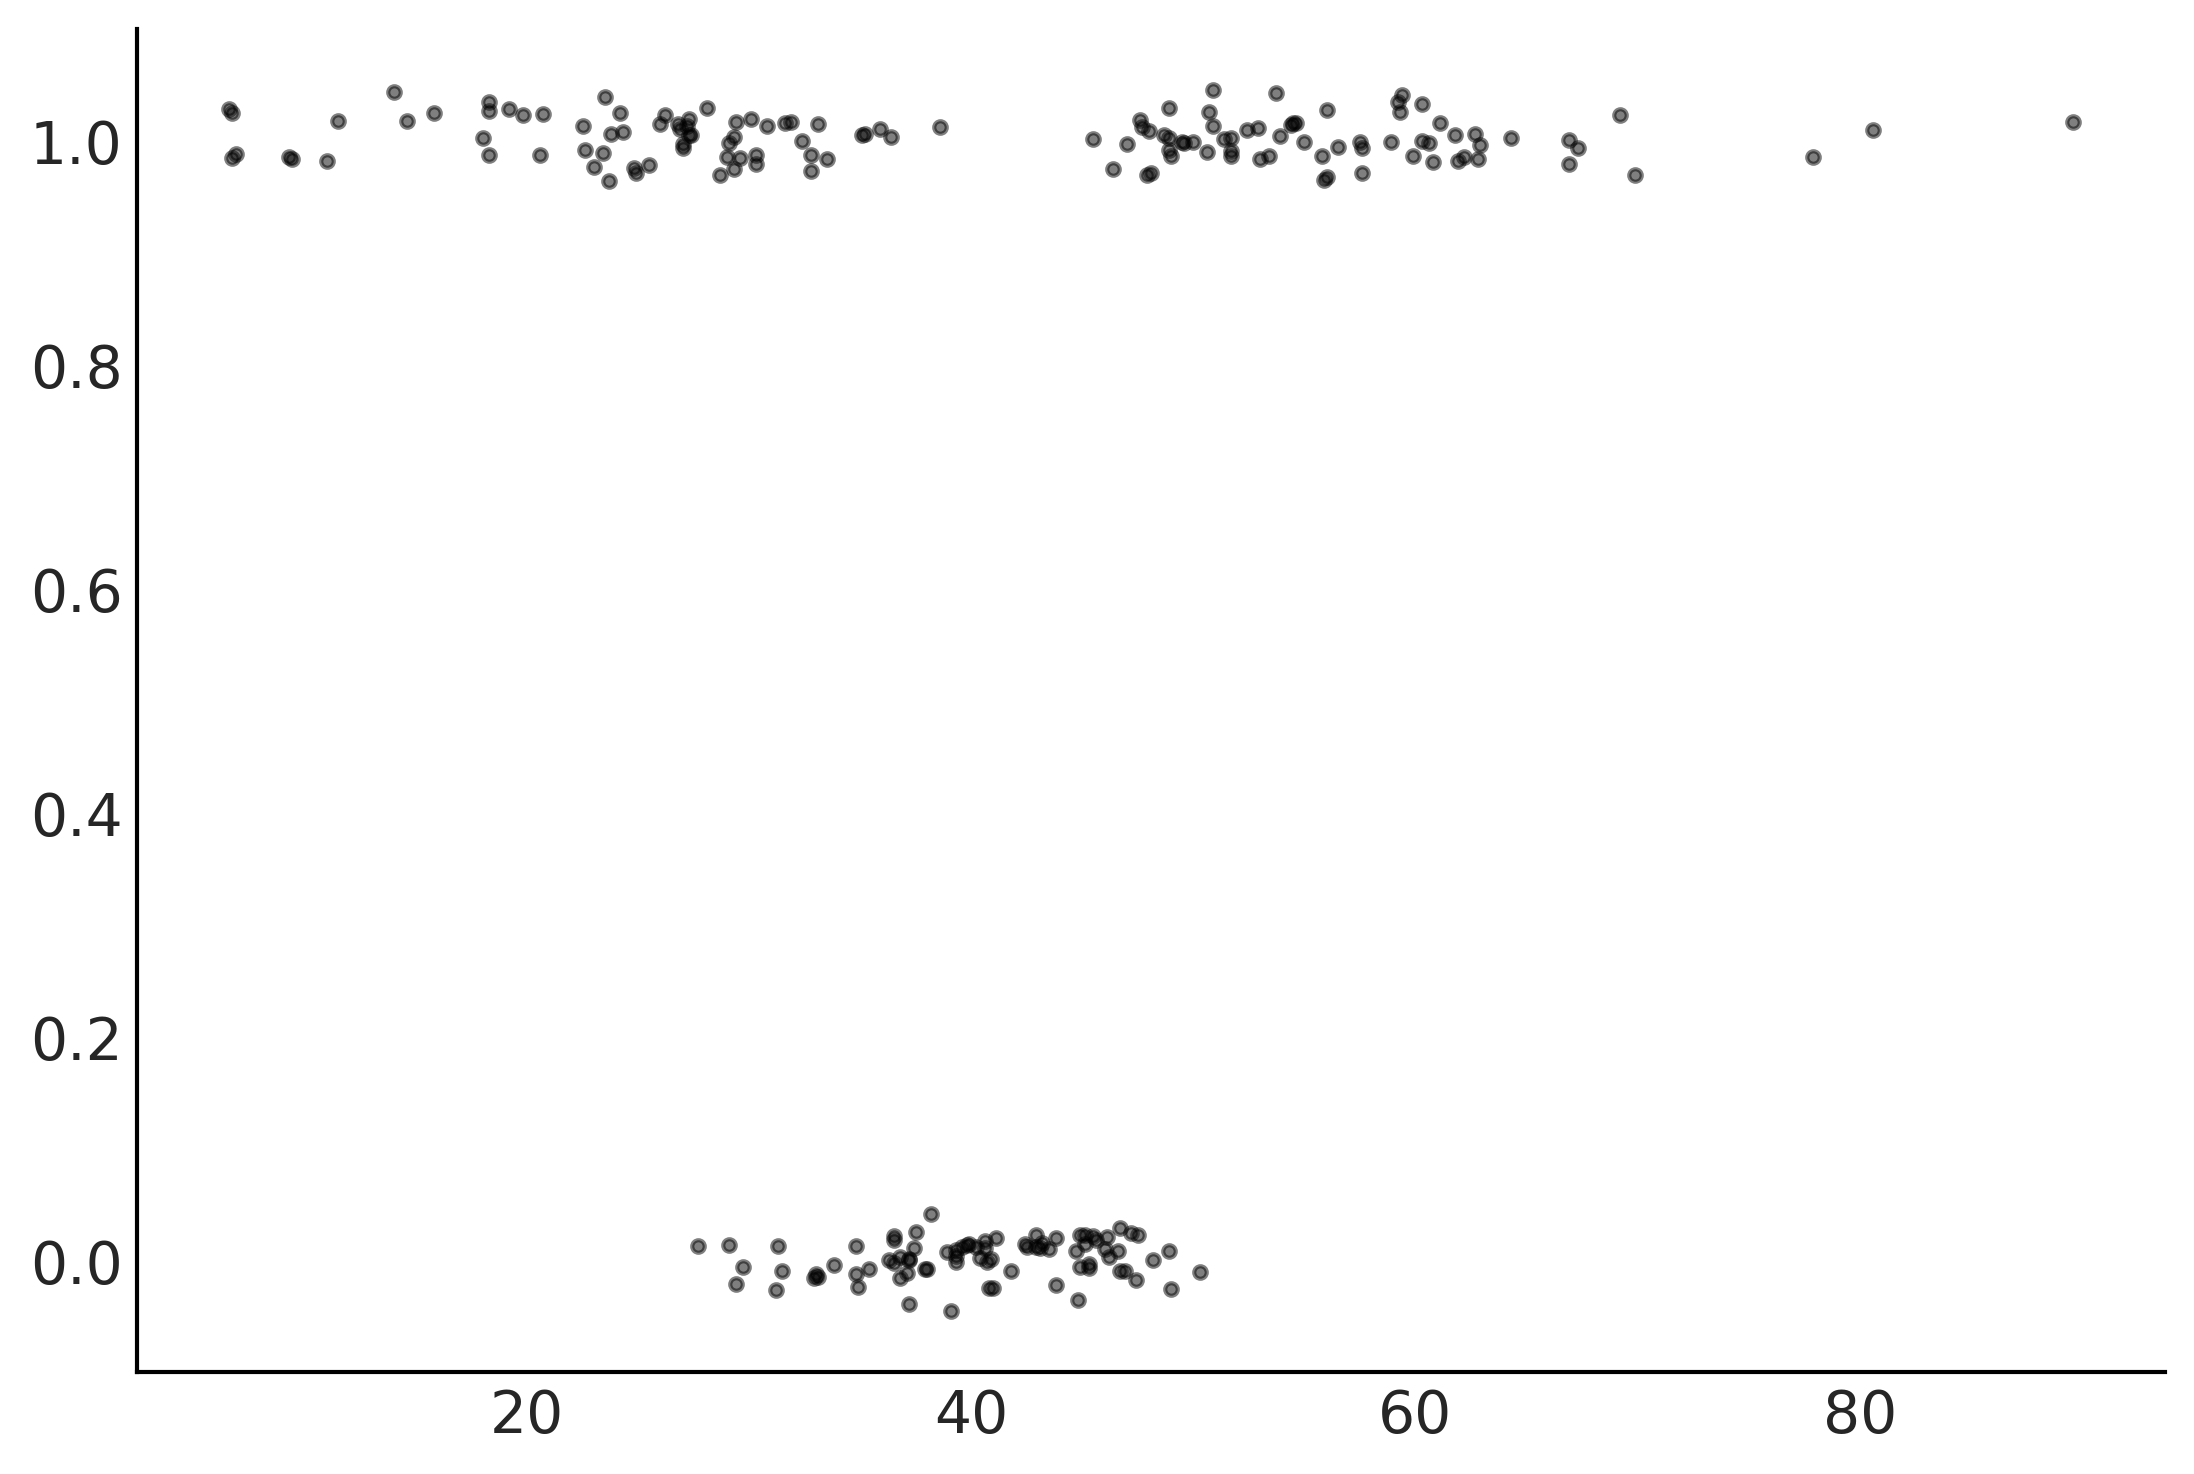

In [34]:
space_in = pd.read_csv("../data/space_influenza.csv")
X = np.atleast_2d(space_in["age"]).T
Y = space_in["sick"]


Y_jittered = np.random.normal(Y, 0.02)
plt.plot(X[:,0], Y_jittered, ".", alpha=0.5)

## Generalized BART Models

### Code 7.2 and Figures 7.6 and 7.7

In [35]:
idatas = {}
ntrees = [2, 10, 20, 50]
for ntree in ntrees:
    with pm.Model() as bart_b:
        μ = pmb.BART('μ', X, Y, m=ntree,
                   )
        p = pm.Deterministic("p", pm.math.sigmoid(μ))
        y = pm.Bernoulli('y', p, observed=Y)
        idata_bart_b = pm.sample(2000, idata_kwargs={"log_likelihood": True})
        idatas[f"{ntree}"] = idata_bart_b

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


In [ ]:
cmp = az.compare(idatas)
cmp

/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
50,0,-56.535652,3.137201,0.000000,1.000000e+00,6.455925,0.000000,False,log
20,1,-62.158967,5.289335,5.623315,0.000000e+00,6.413707,0.391046,False,log
10,2,-70.065170,9.447659,13.529518,0.000000e+00,6.390646,0.769746,False,log
2,3,-112.684310,25.929014,56.148658,8.699885e-11,5.030852,2.666808,False,log


/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


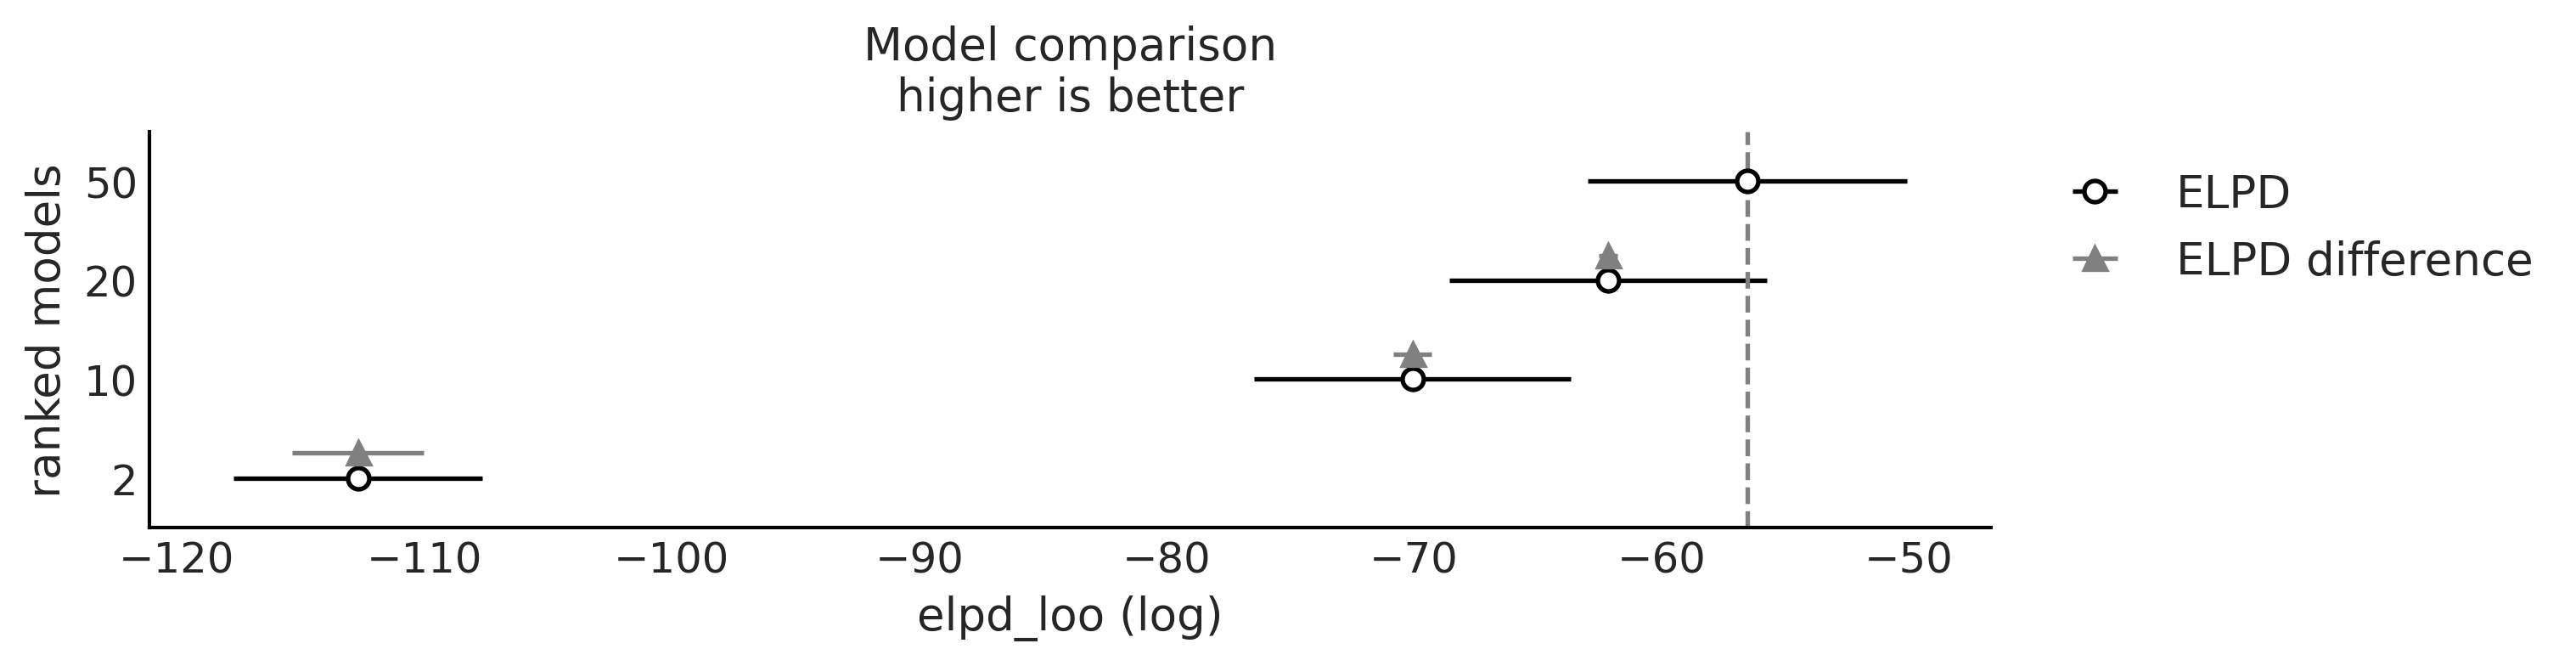

In [ ]:
az.plot_compare(cmp, figsize=(10, 2.5))
plt.savefig("img/chp07/BART_space_flu_comp.png")

/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=F

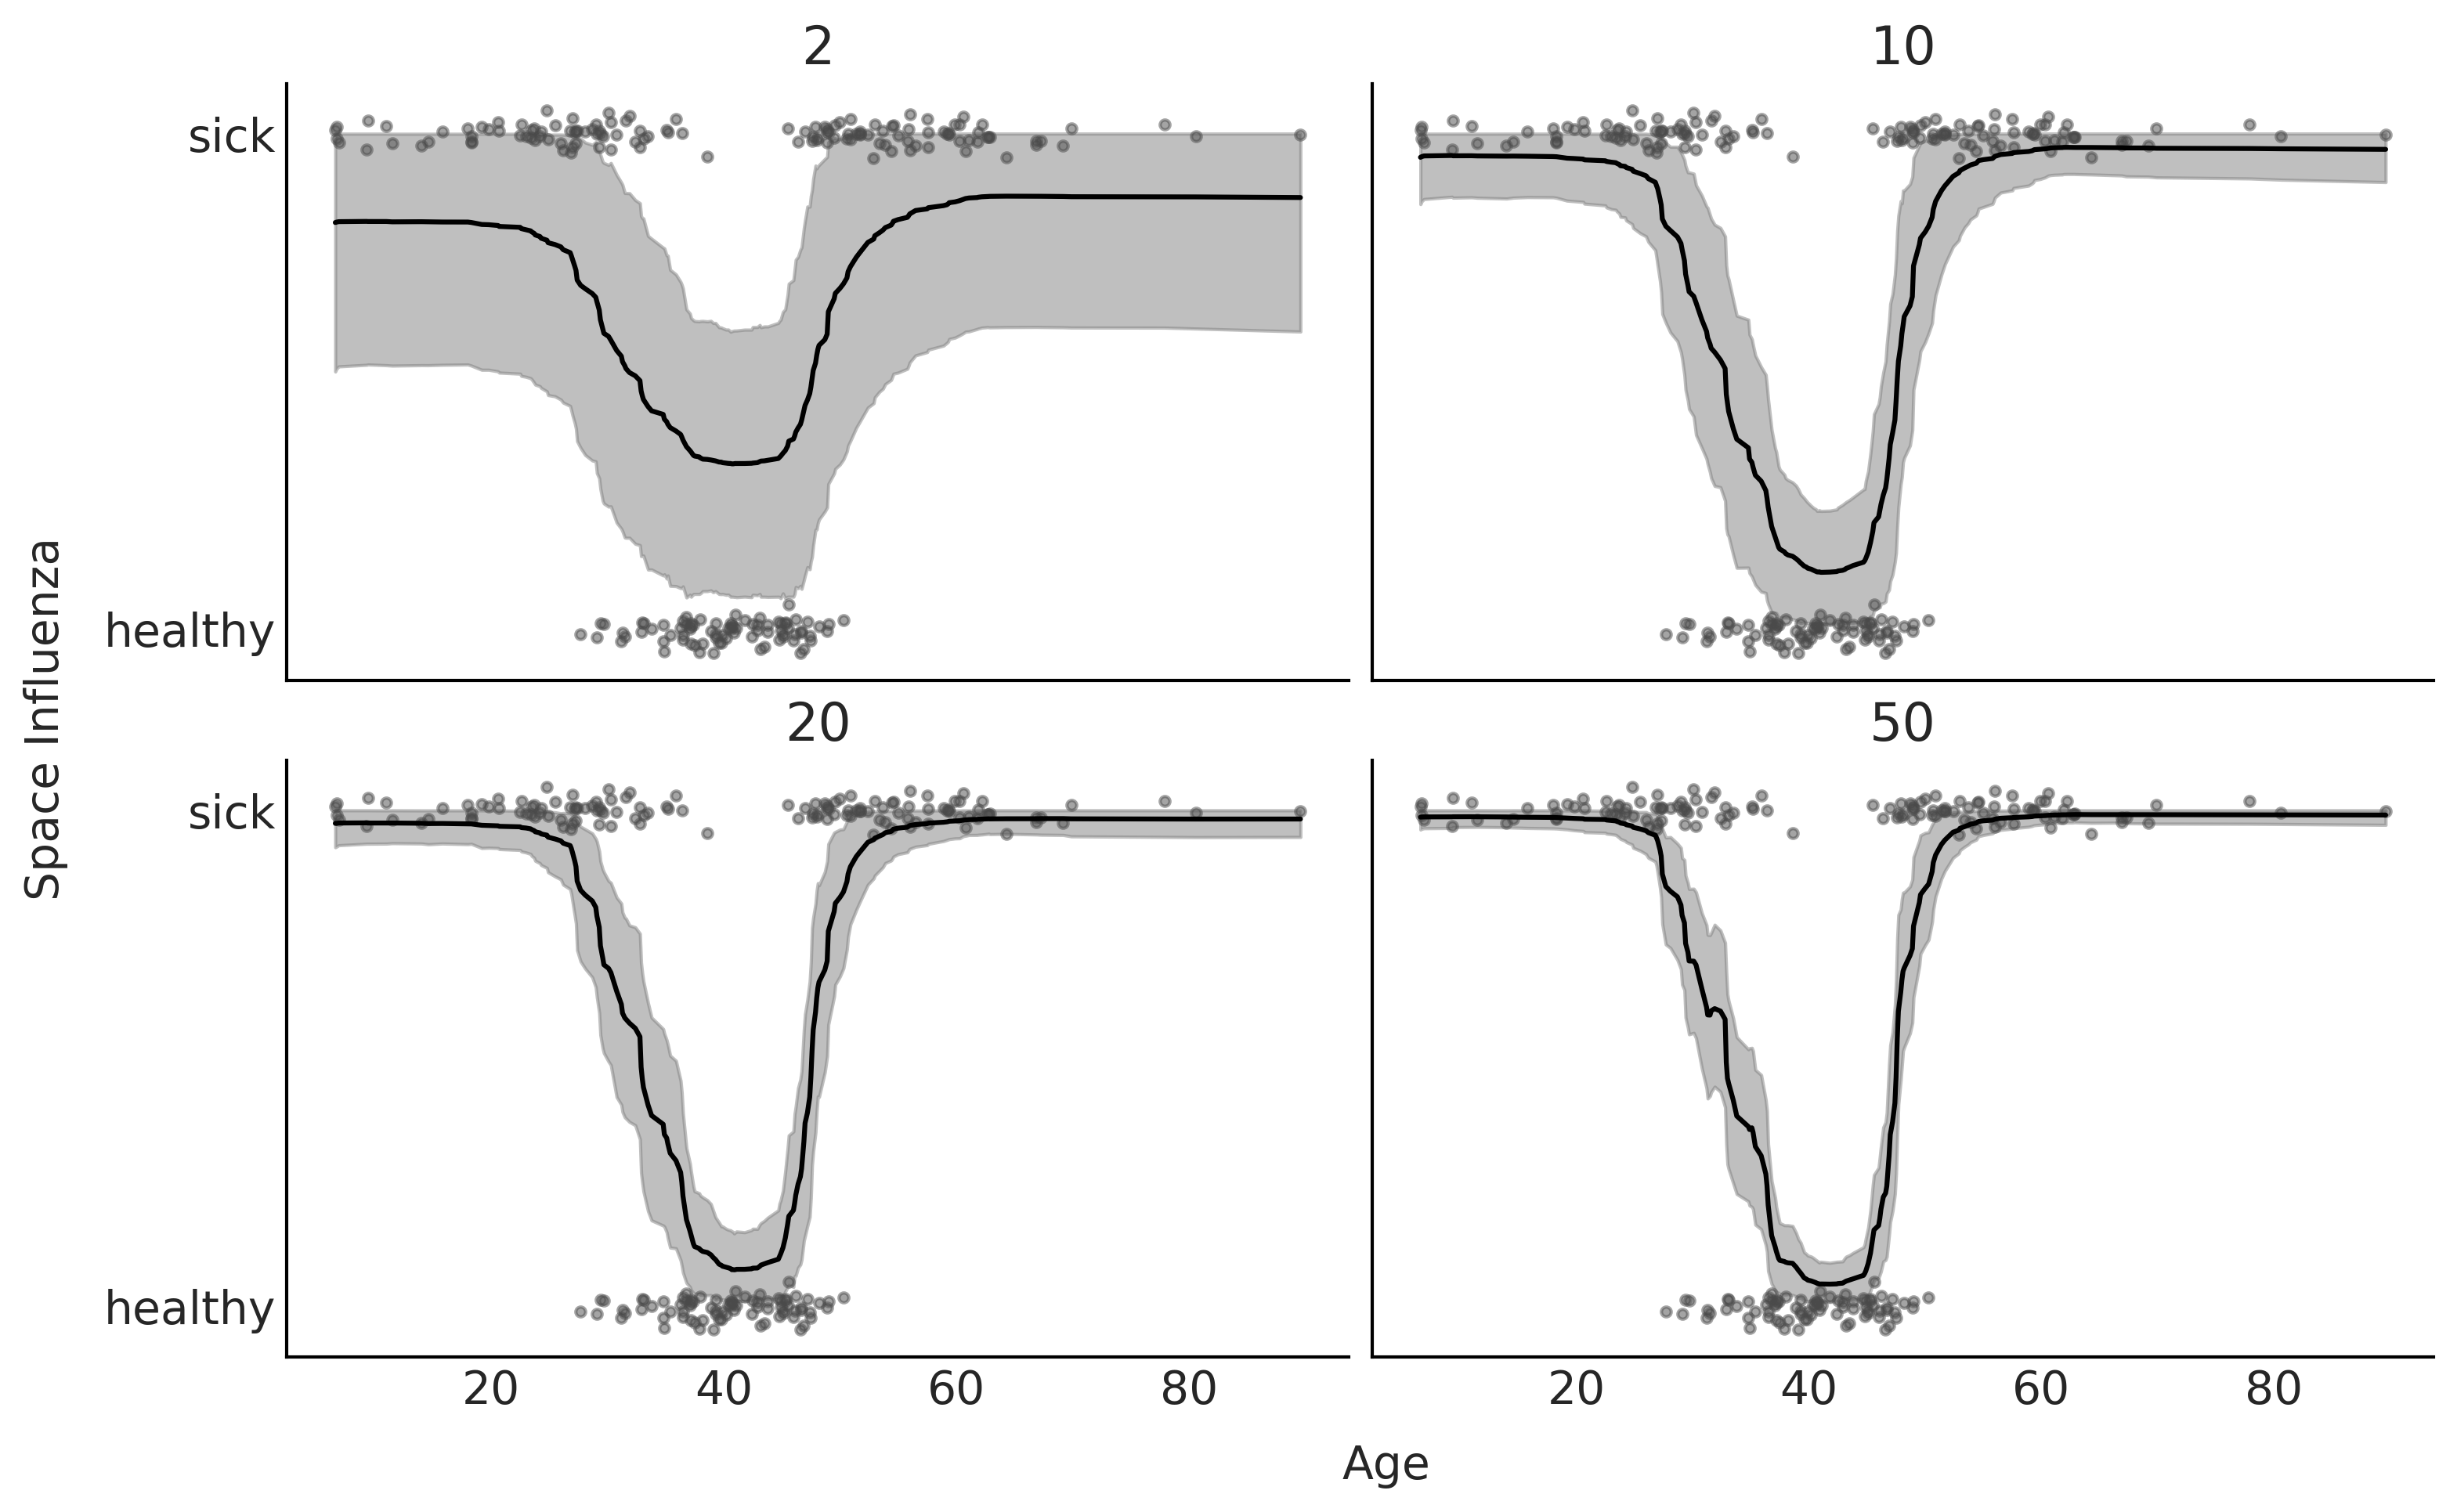

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10, 6), sharey=True, sharex=True)

for ax, (mtree, idata) in zip(np.ravel(axes), idatas.items()):
    μs = idata.posterior["p"].stack({"draws":["chain",  "draw"]})

    ax.plot(X, Y_jittered, "C1.", alpha=0.5)

    X_idx = np.argsort(X[:,0])
    ax.plot(X[:,0][X_idx], np.mean(μs, 1)[X_idx], 'k-') 
    
    az.plot_hdi(X[:,0], μs.T, ax=ax, smooth=False, color="0.5") # una banda con el 94% Highest Density Interval
    ax.set_title(mtree)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["healthy", "sick"])
fig.text(0.55, -0.04, 'Age', ha='center', size=14)
fig.text(-0.03, 0.5, 'Space Influenza', va='center', size=14, rotation=90)
plt.savefig("img/chp07/BART_space_flu_fit.png", bbox_inches="tight")

## Interpretability of BARTs

### Figure 7.8

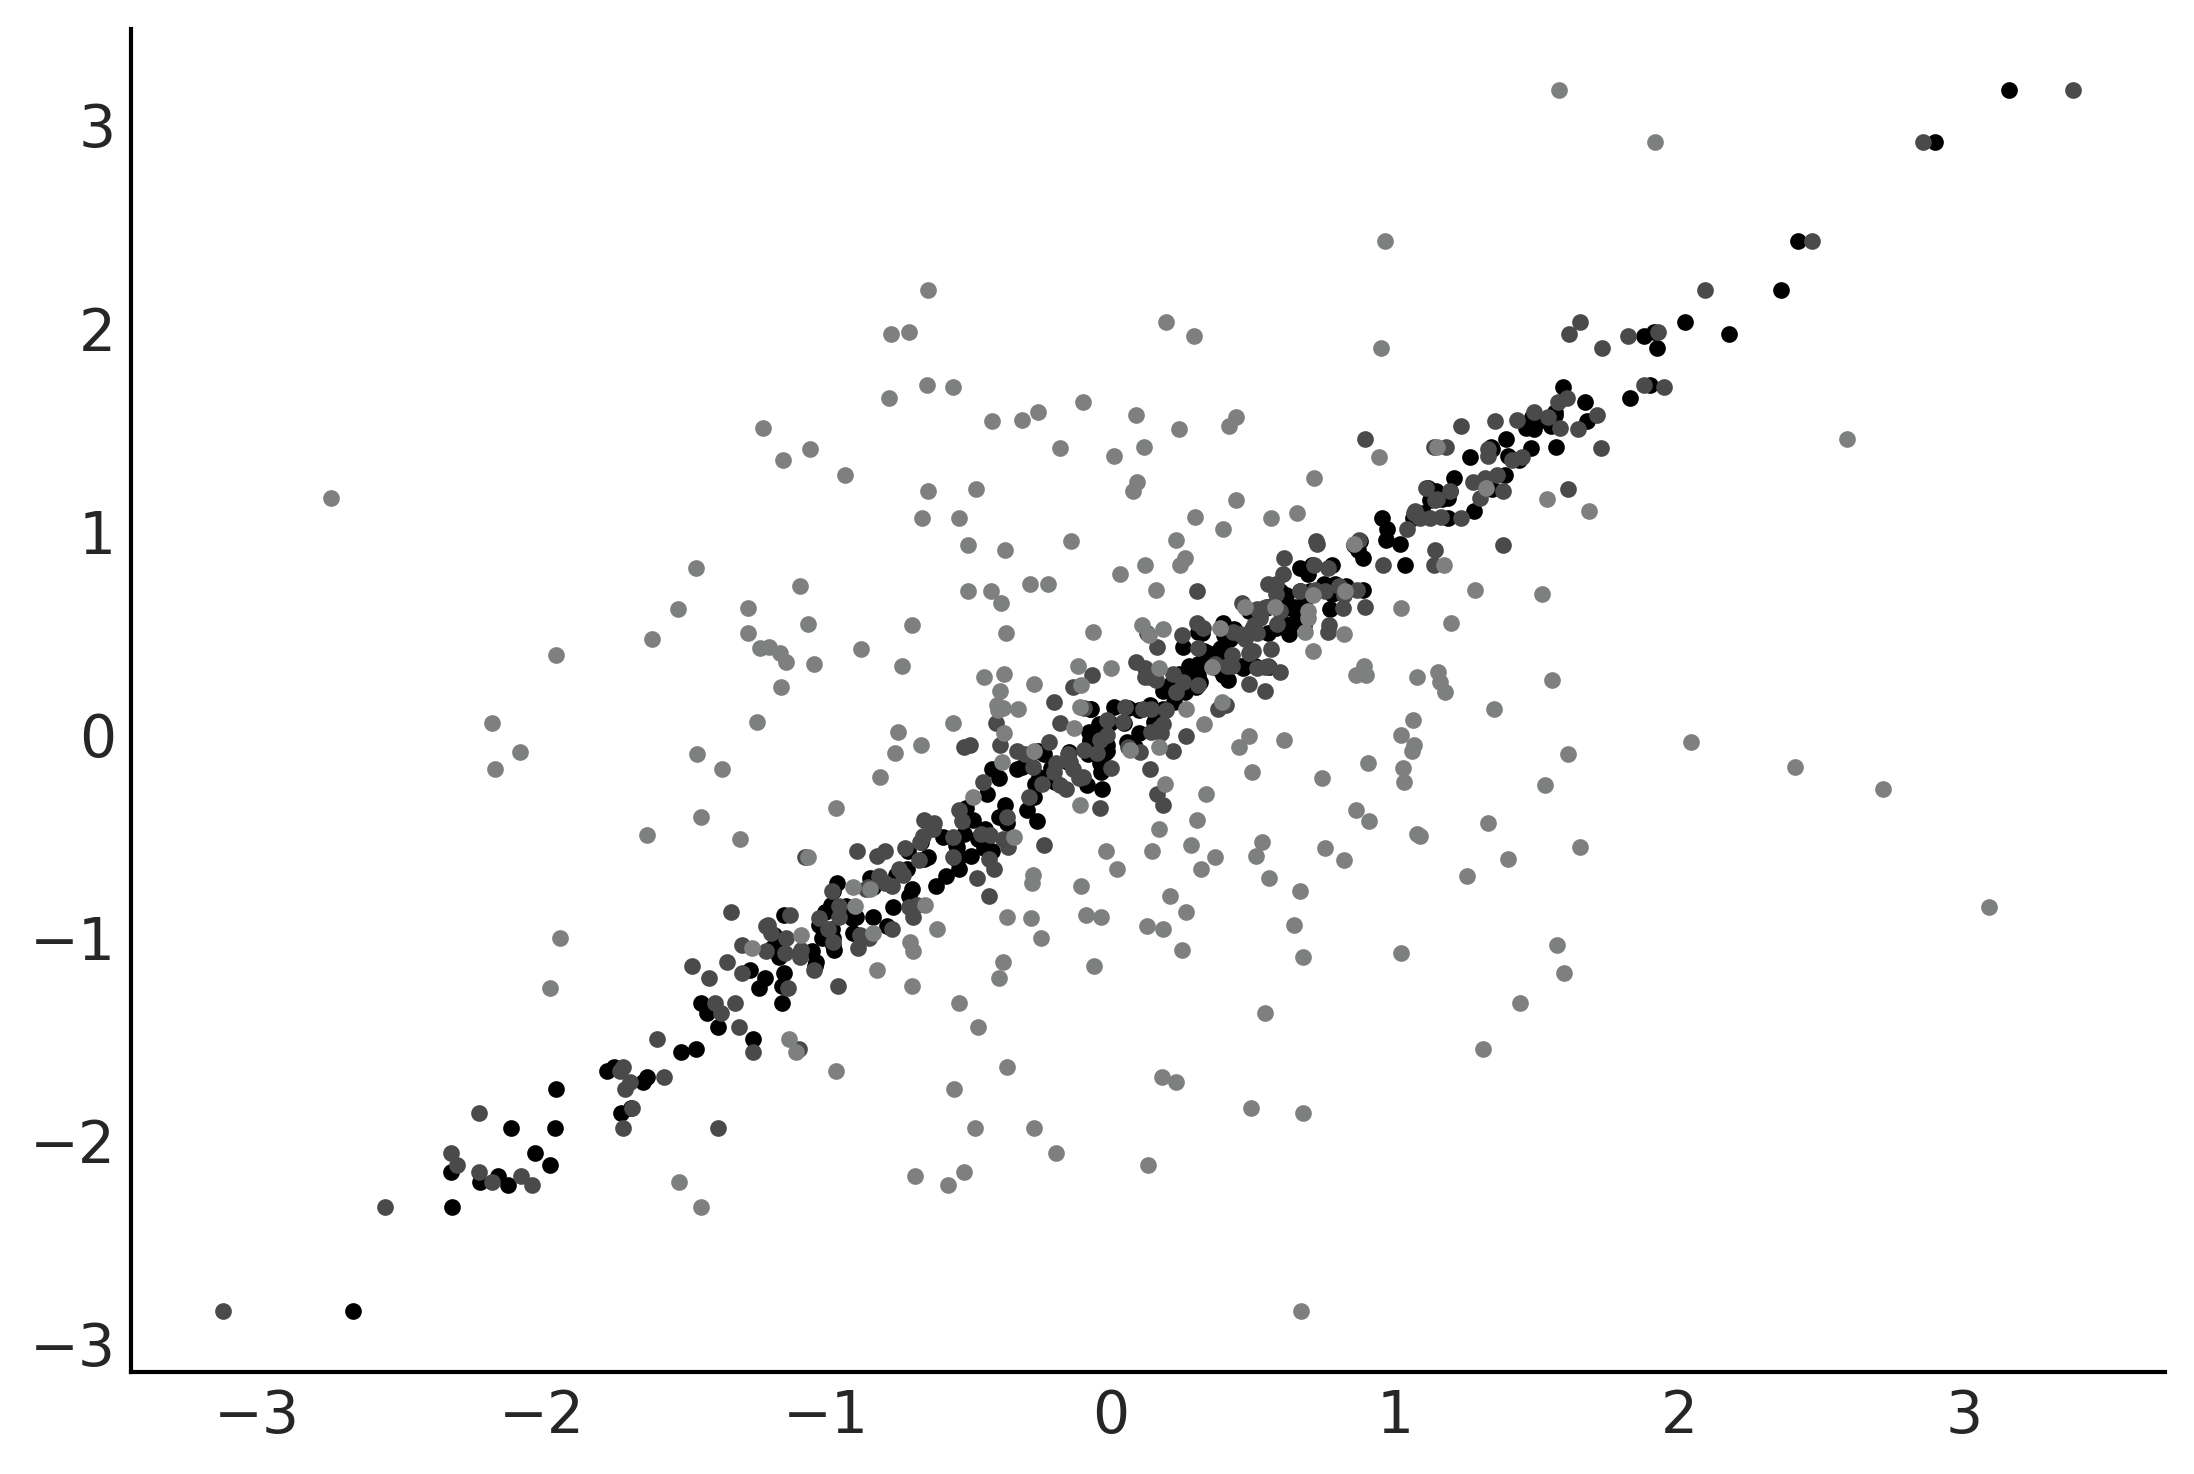

In [ ]:
X = np.random.normal(0, 1, size=(3, 250)).T
Y = np.random.normal(0, 1, size=250)
X[:,0] = np.random.normal(Y, 0.1)
X[:,1] = np.random.normal(Y, 0.2)

plt.plot(X, Y, '.');

In [ ]:
with pm.Model() as model:
    μ = pmb.BART('μ', X, Y, m=50)
    σ = pm.HalfNormal('σ', 1)
    y = pm.Normal('y', μ, σ, observed=Y)
    trace_u = pm.sample(2000, tune=1000, random_seed=42)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 88 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


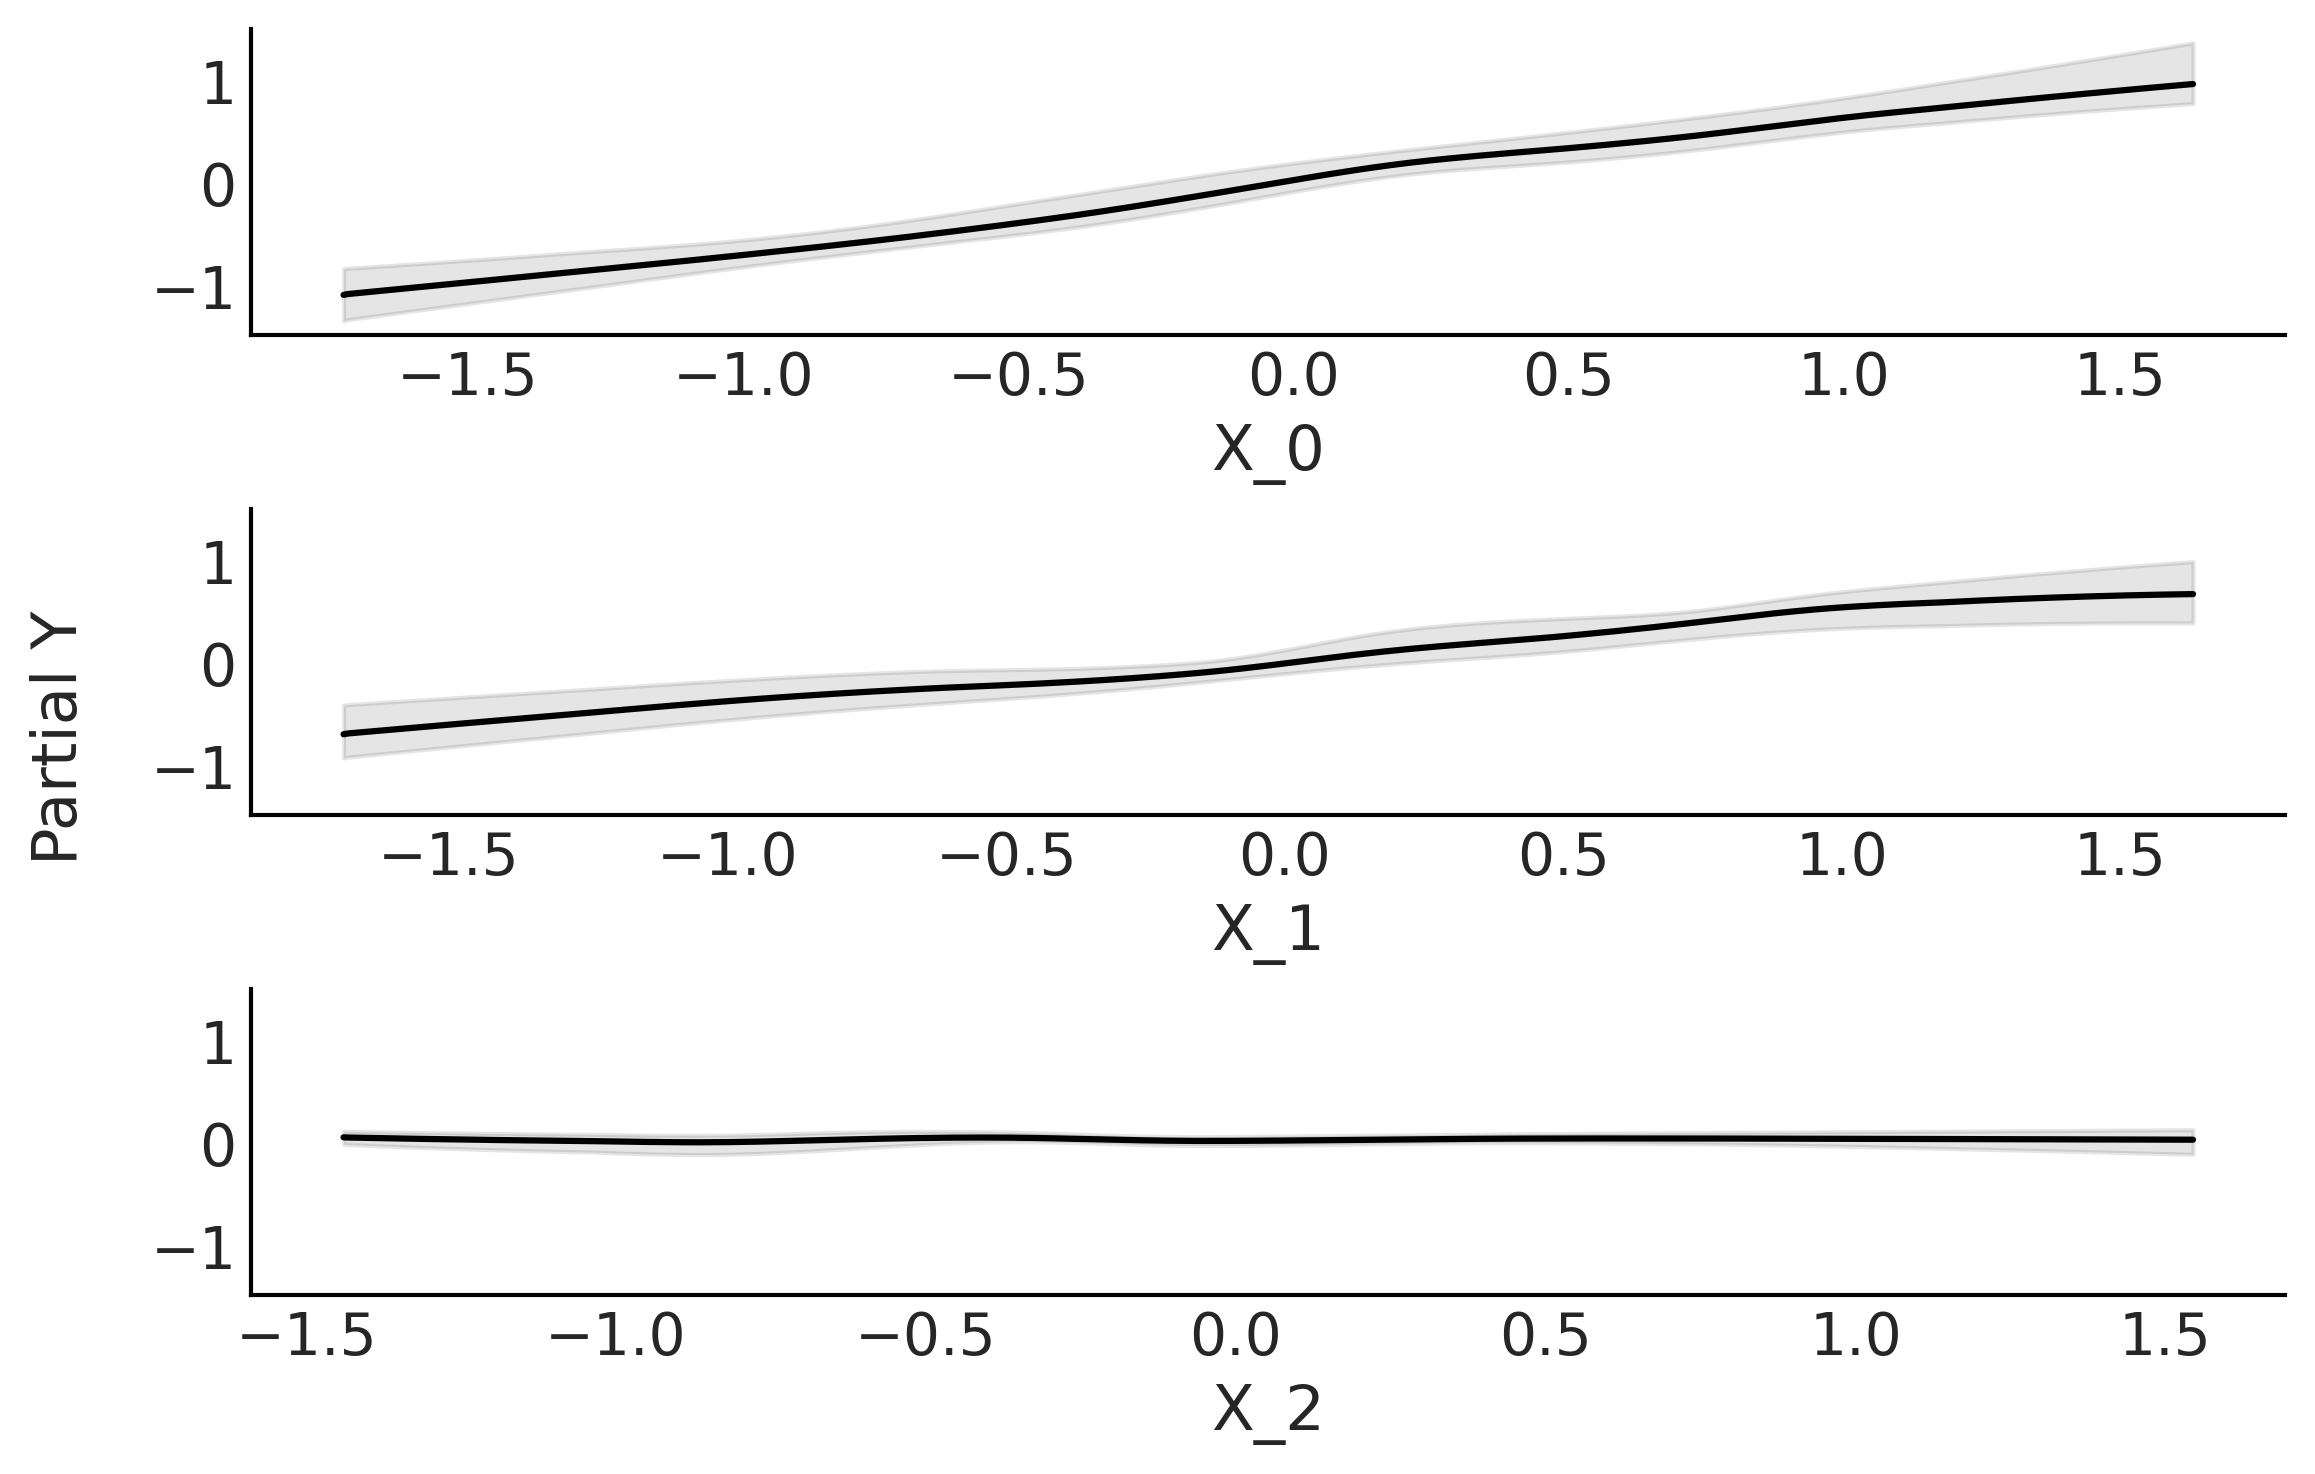

In [ ]:
pmb.plot_pdp(μ, X, grid="long")
plt.savefig("img/chp07/partial_dependence_plot.png", bbox_inches="tight")

### Figures 7.9, 7.10, and 7.11 

In [ ]:
X = data[["hour", "temperature", "humidity", "windspeed"]]
Y = data["count"]

In [ ]:
with pm.Model() as bart_model_g:
    σ = pm.HalfNormal('σ', Y.std())
    μ = pmb.BART('μ', X, Y, m=50)
    y = pm.Normal('y', μ, σ, observed=Y)
    trace_bart = pm.sample(2000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


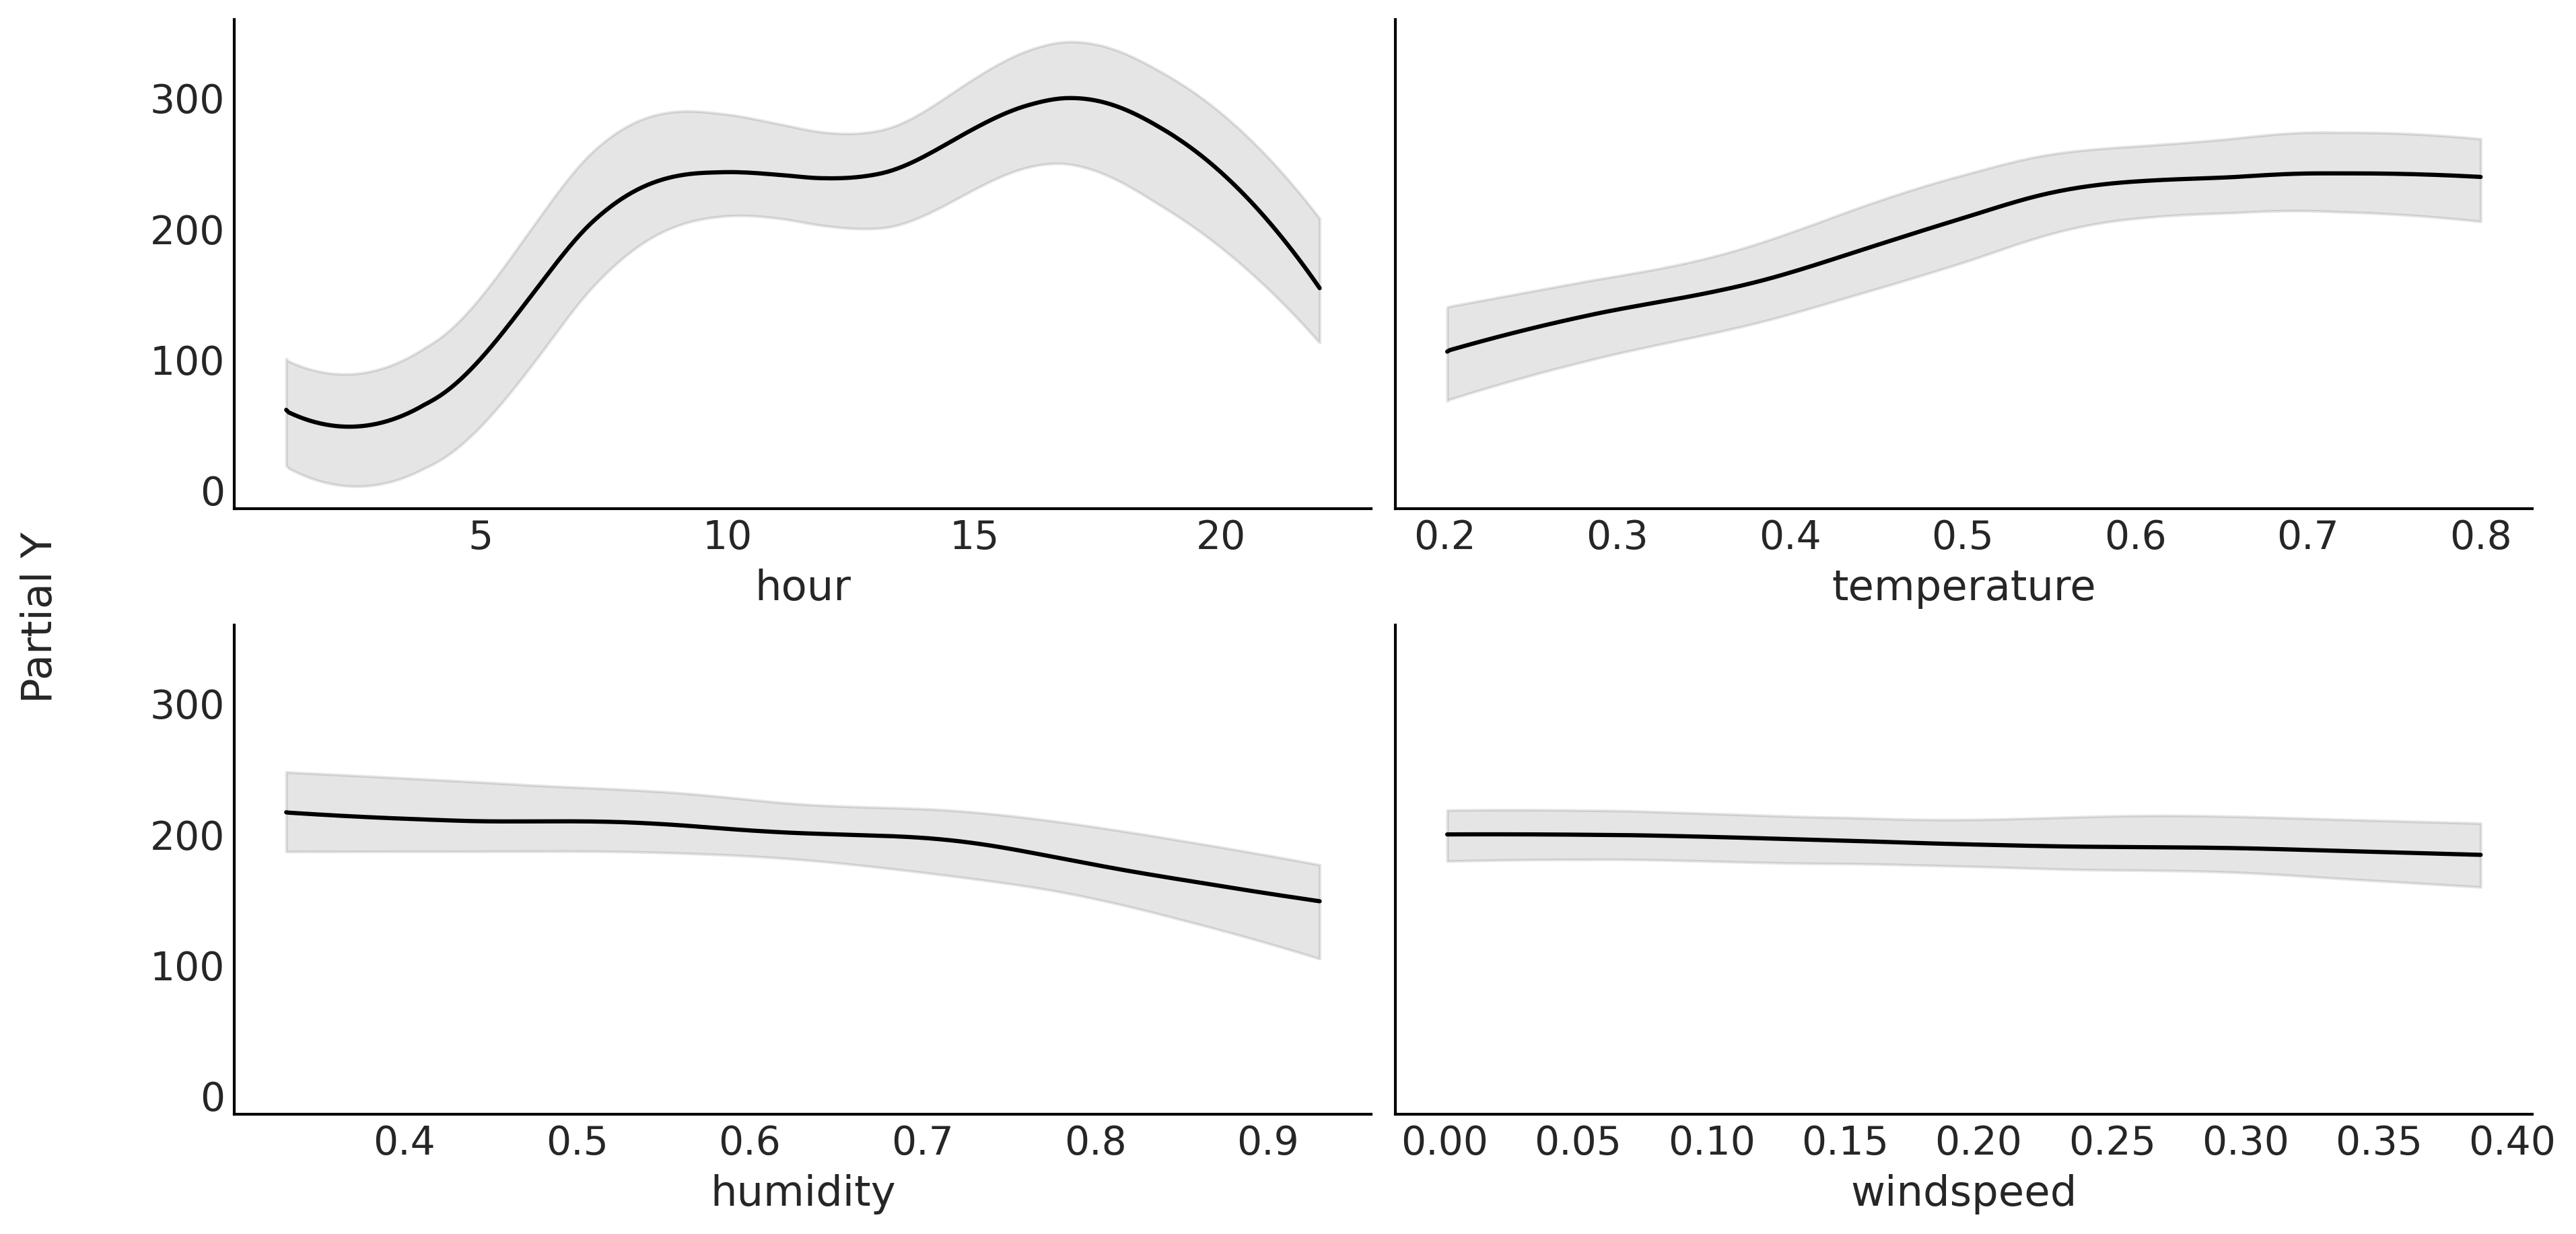

In [ ]:
pmb.plot_pdp(μ, X, grid=(2, 2), figsize=(12, 6), sharey=True)
plt.savefig("img/chp07/partial_dependence_plot_bikes.png", bbox_inches="tight")

(30, 348, 1)
(30, 348, 1)
(30, 348, 1)
(30, 348, 1)


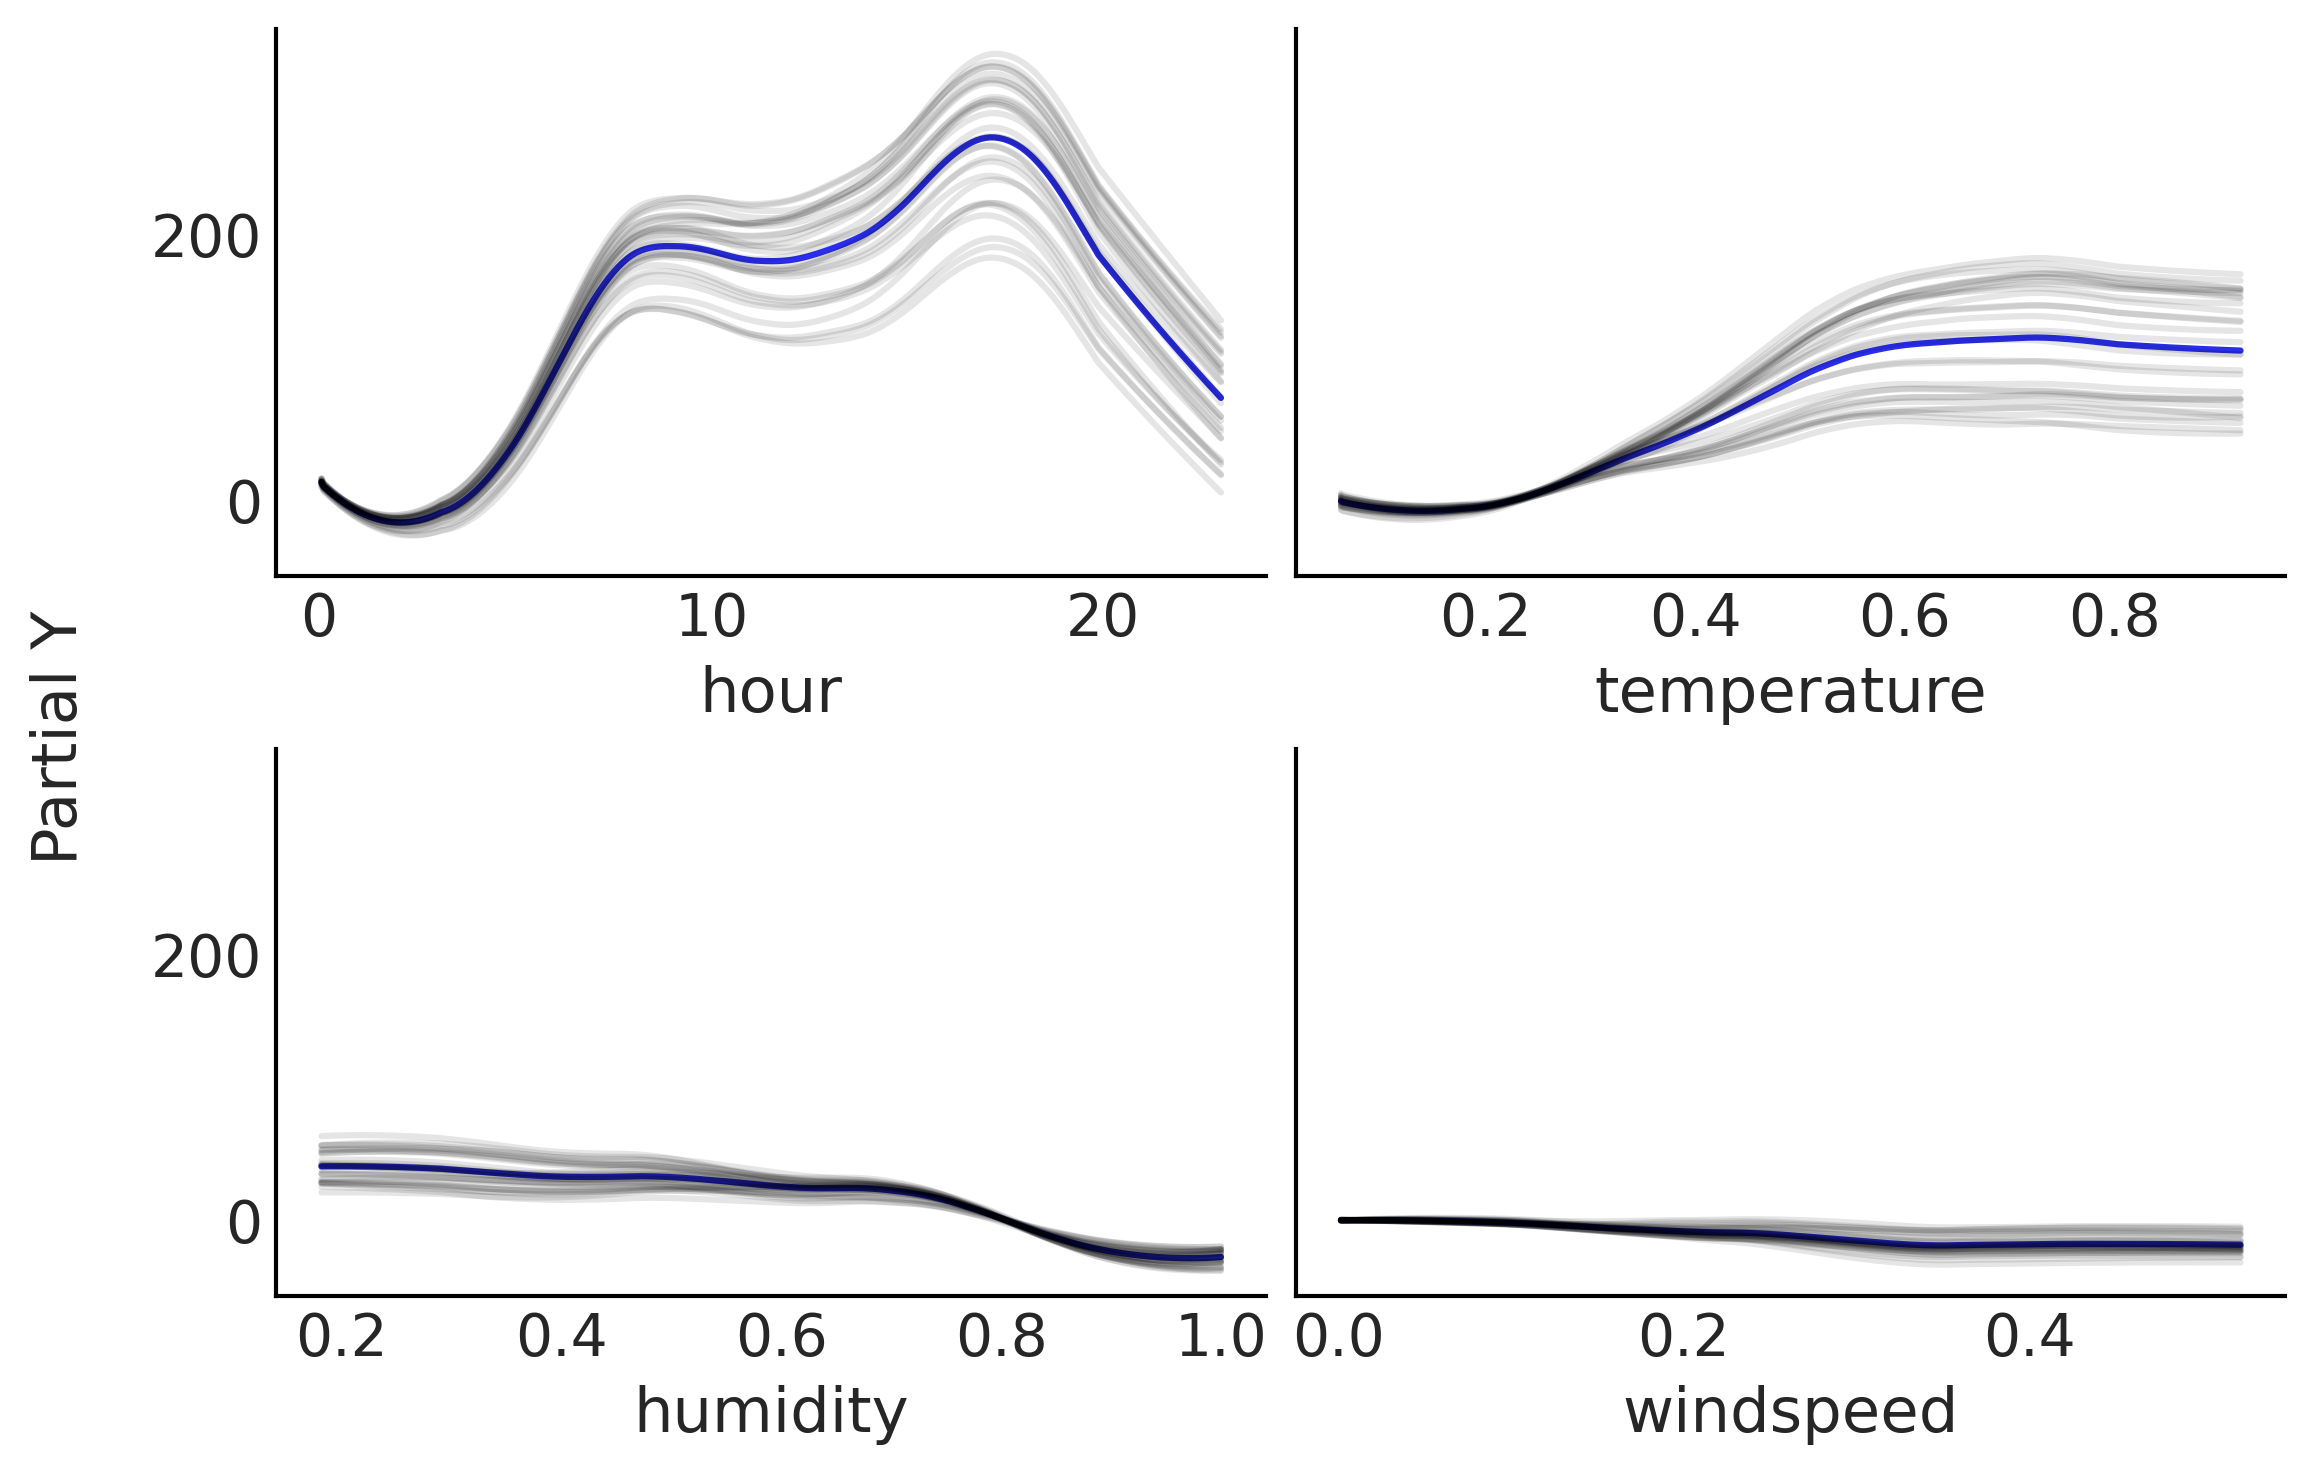

In [ ]:
pmb.plot_ice(μ, X, grid=(2,2), smooth=True, color_mean="C4")
plt.savefig("img/chp07/individual_conditional_expectation_plot_bikes.png", bbox_inches="tight")

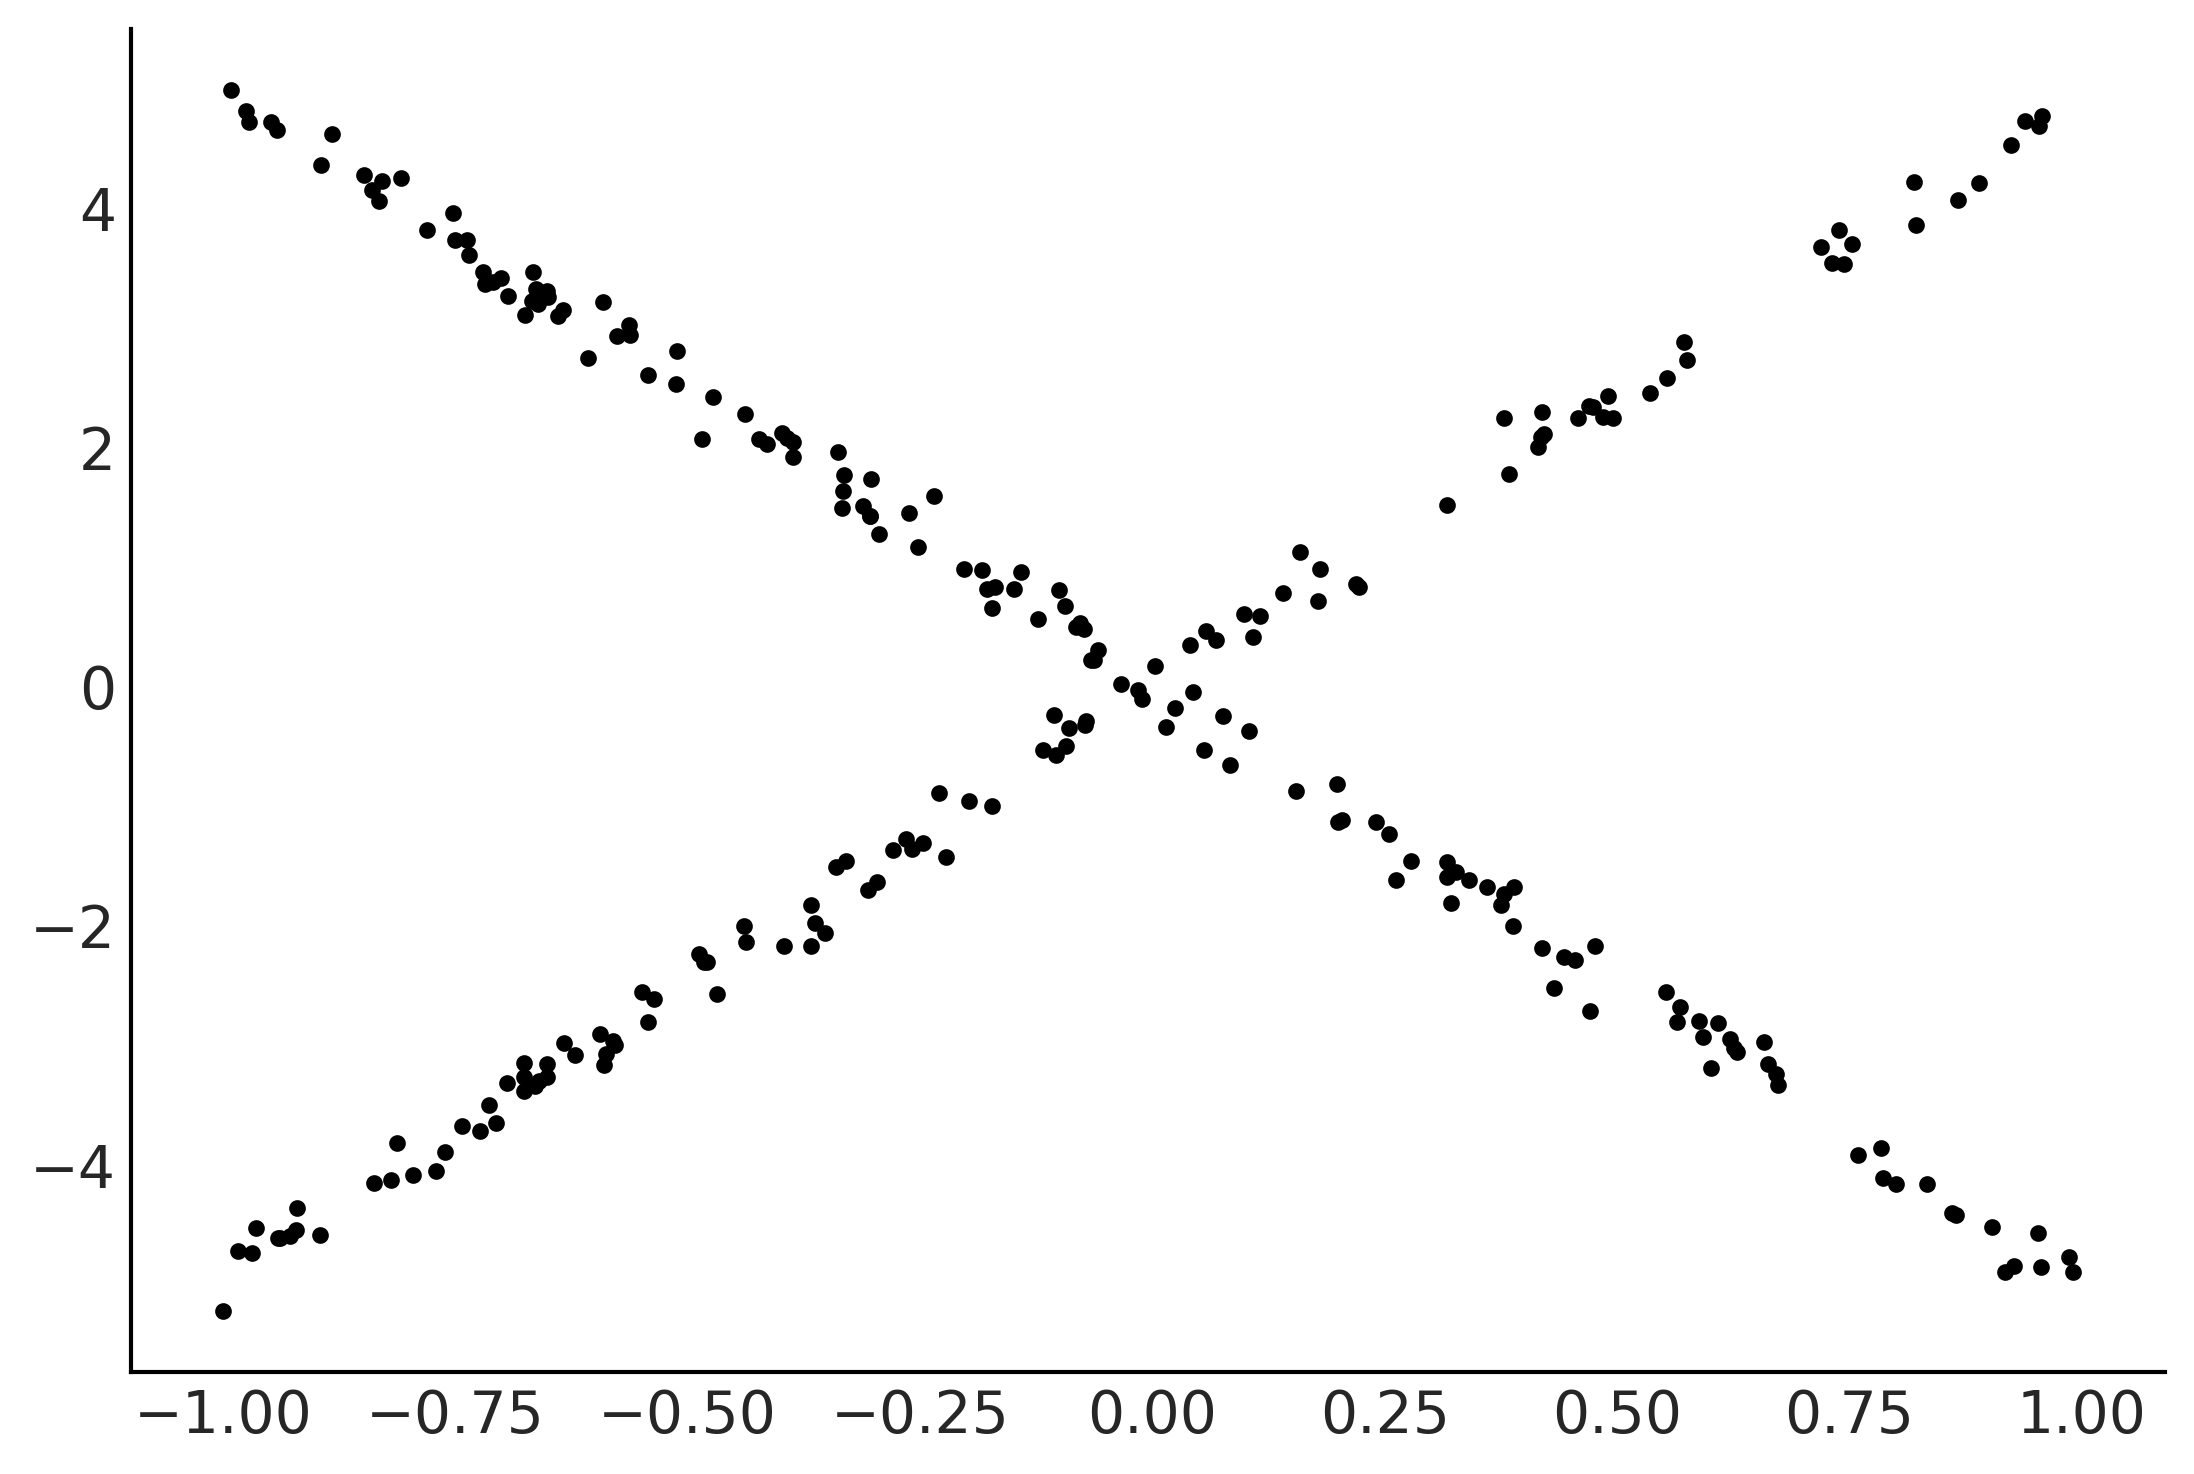

In [ ]:
X = np.random.uniform(-1, 1, (250, 3))
Z = np.where(X[:,2] >= 0,  np.zeros_like(X[:,2]), np.ones_like(X[:,2]))
e = np.random.normal(0, 0.1, 250)
Y = 0.2*X[:,0] - 5*X[:,1] + 10*X[:,1] * Z + e


plt.plot(X[:,1], Y, '.');

In [ ]:
with pm.Model() as model:
    μ = pmb.BART('μ', X, Y, m=200)
    σ = pm.HalfNormal('σ', 1)

    y = pm.Normal('y', μ, σ, observed=Y)
    trace_u = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 162 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


(30, 250, 1)


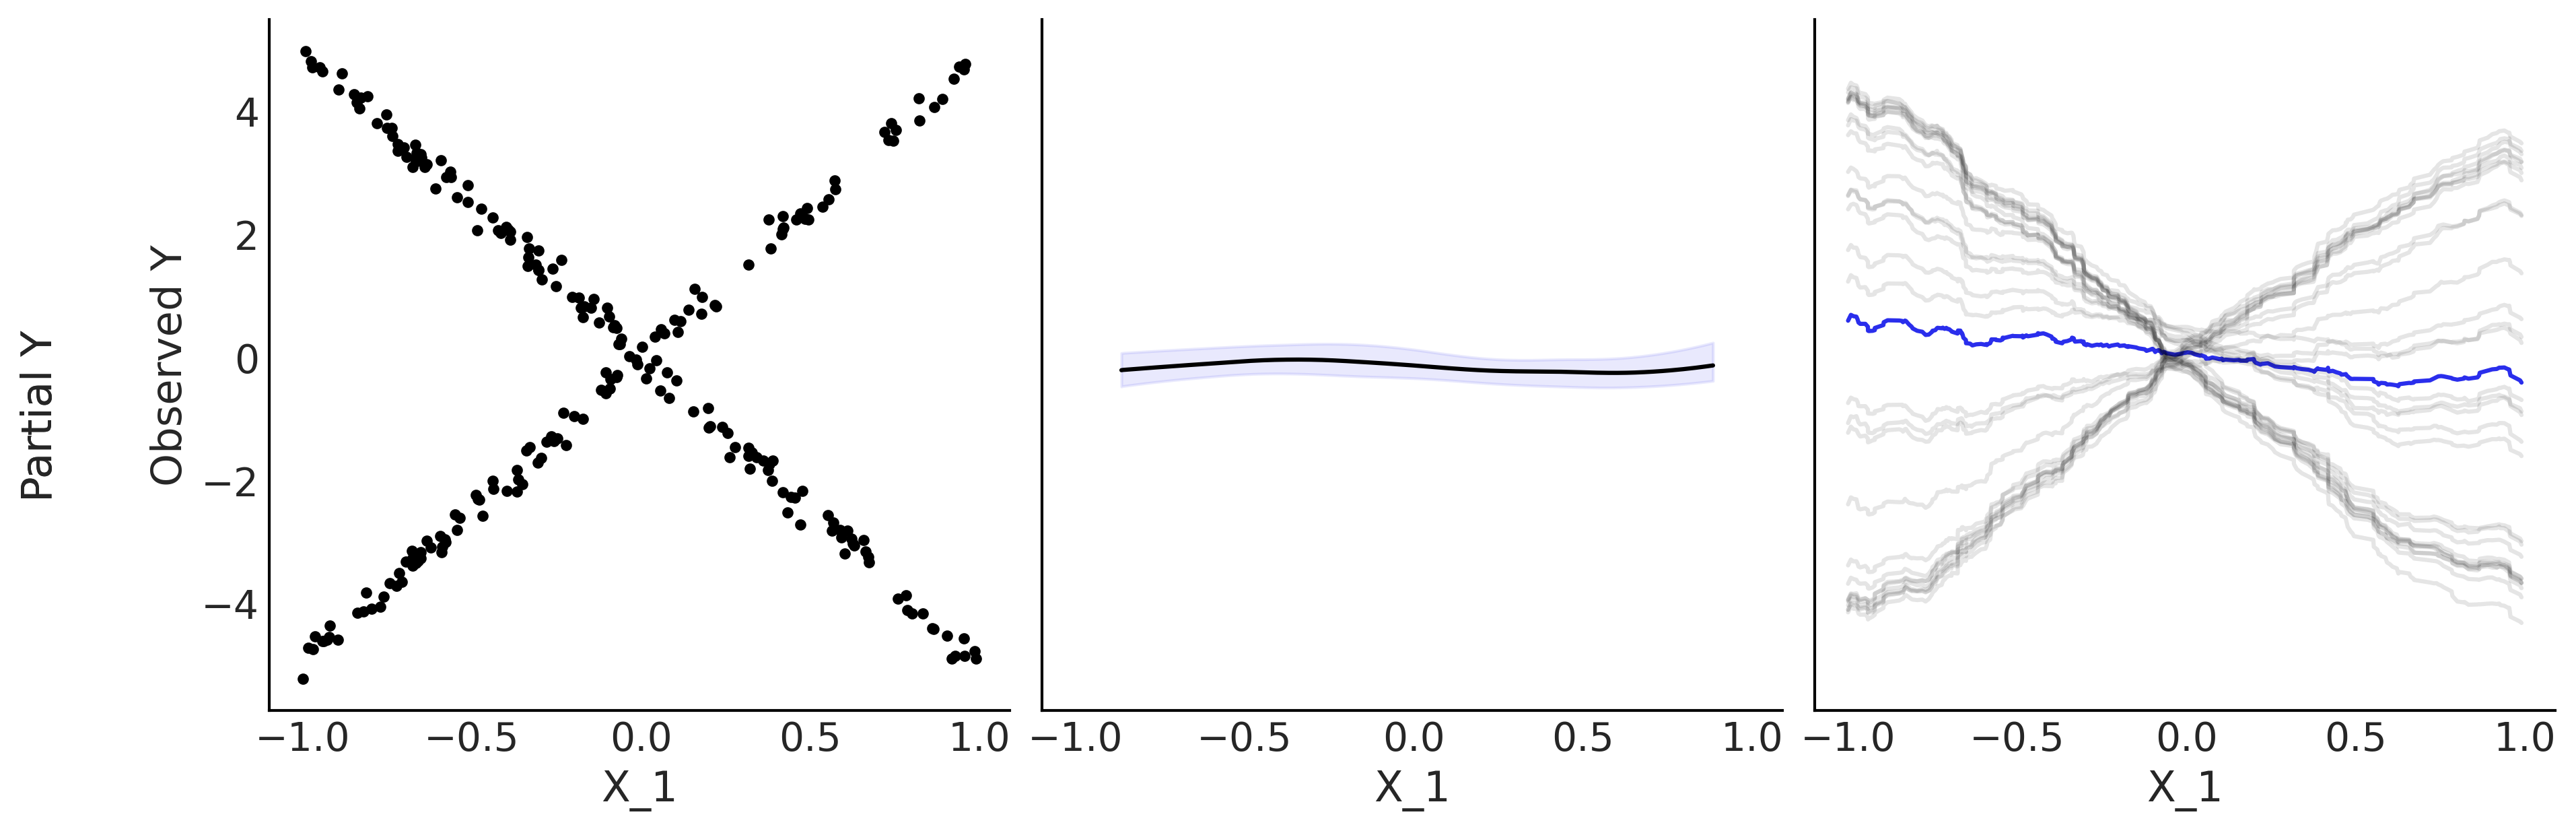

In [ ]:
_, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)
ax[0].plot(X[:,1], Y, '.');
ax[0].set_xlabel("X_1")
ax[0].set_ylabel("Observed Y")
pmb.plot_pdp(μ, X, smooth=True, color="C4", var_idx=[1], ax=ax[1])
pmb.plot_ice(μ, X, centered=False, smooth=False, color_mean="C4", var_idx=[1], ax=ax[2])
plt.savefig("img/chp07/pdp_vs_ice_toy.png", bbox_inches="tight")

## Variable Selection

The new version of BART uses a different algorithm to compute the variable importance. With this method the variable importance is robust to the number of trees and results are easier to interpret. Instead of reporting the value of the variable importance we report the value of R² (the square of the pearson correlation coefficient) between the model with all variables, versus model with a subset of the variables. To see how this works in practice we are going to fit the 3 same models as in the book, but with the new version of BART.

In [ ]:
Xs = []
Ys = []


Y = np.random.normal(0, 1, 100)
X = np.random.normal(0, 1, (100, 10))
X[:,0] = np.random.normal(Y, 0.1)
X[:,1] = np.random.normal(Y, 0.2)
Xs.append(X)
Ys.append(Y)


X = np.random.uniform(0, 1, size=(100, 10))
fx = 10 * np.sin(np.pi*X[:,0]* X[:,1]) + 20*(X[:,2] - 0.5)**2 + 10*X[:,3] + 5*X[:,4]
Y =  np.random.normal(fx, 1)
Xs.append(X)
Ys.append(Y)


Y = np.random.normal(0, 1, 100)
X = np.random.normal(0, 1, (100, 10))
Xs.append(X)
Ys.append(Y)

In [ ]:
idatas = []
bart_rvs = []

for X, Y in zip(Xs, Ys):
    with pm.Model() as bart:
        σ = pm.HalfNormal('σ', Y.std())
        μ = pmb.BART('μ', X, Y)
        y = pm.Normal('y', μ, σ, observed=Y)
        bart_rvs.append(μ)
        idatas.append(pm.sample())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Figure 7.12

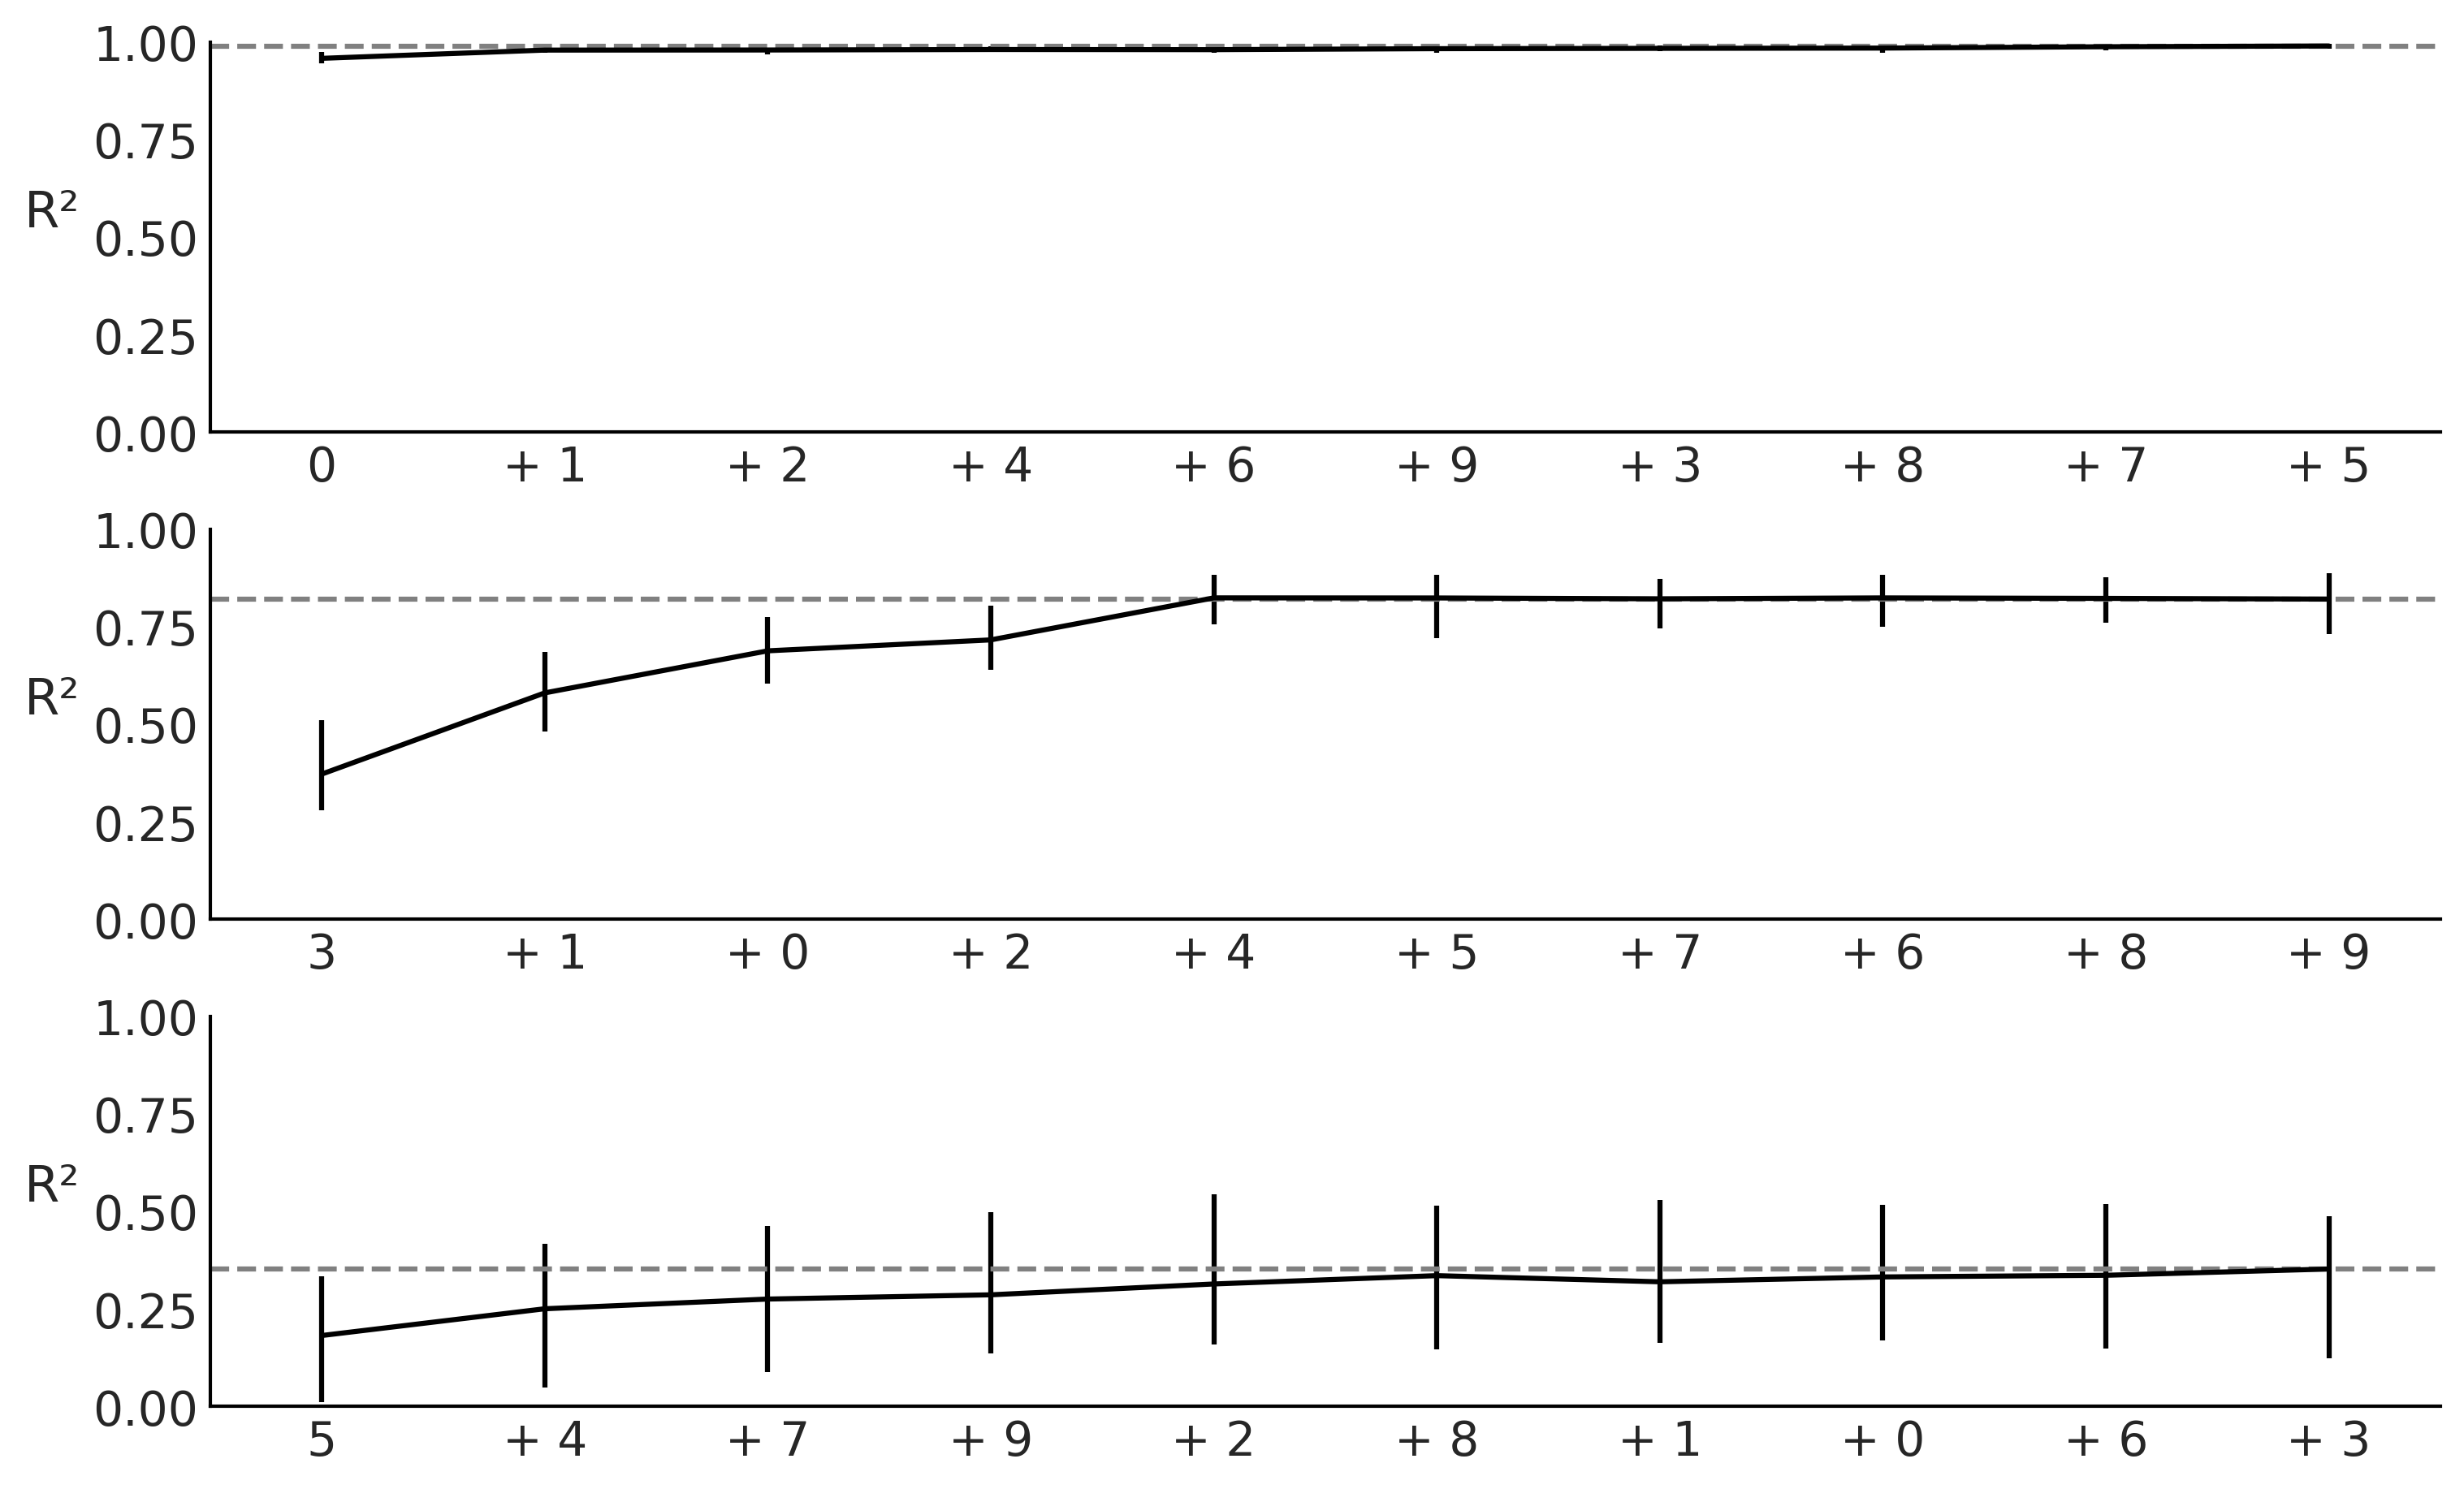

In [ ]:
_, axes = plt.subplots(3, 1, figsize=(10, 6))

for j, X in enumerate(Xs):
    pmb.utils.plot_variable_importance(idatas[j], bart_rvs[j], X, figsize=(10, 5), ax=axes[j])
        
plt.savefig("img/chp07/bart_vi_toy.png", bbox_inches="tight")

In [ ]:
data = pd.read_csv("../data/bikes_hour.csv")
data.sort_values(by='hour', inplace=True)
data = data[::50]
X = data[["hour", "temperature", "humidity", "windspeed"]]
Y = data["count"]

In [ ]:
with pm.Model() as bart:
    σ = pm.HalfNormal('σ', Y.std())
    μ = pmb.BART('μ', X, Y)
    y = pm.Normal('y', μ, σ, observed=Y)
    idata = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


### Figure 7.13

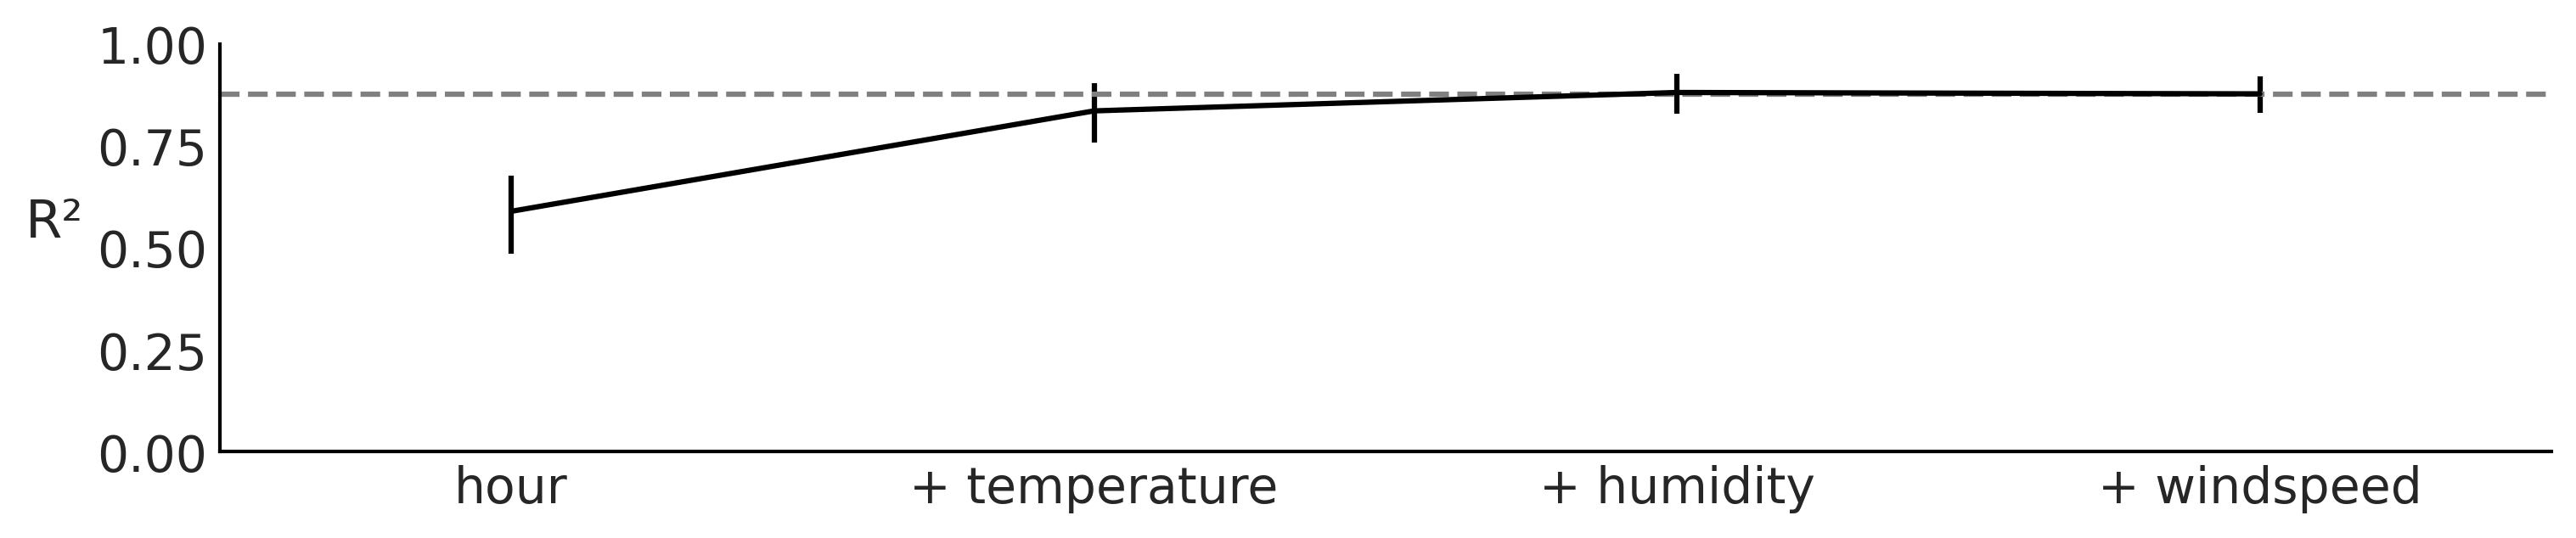

In [ ]:
pmb.utils.plot_variable_importance(idata, μ, X, figsize=(10, 2));